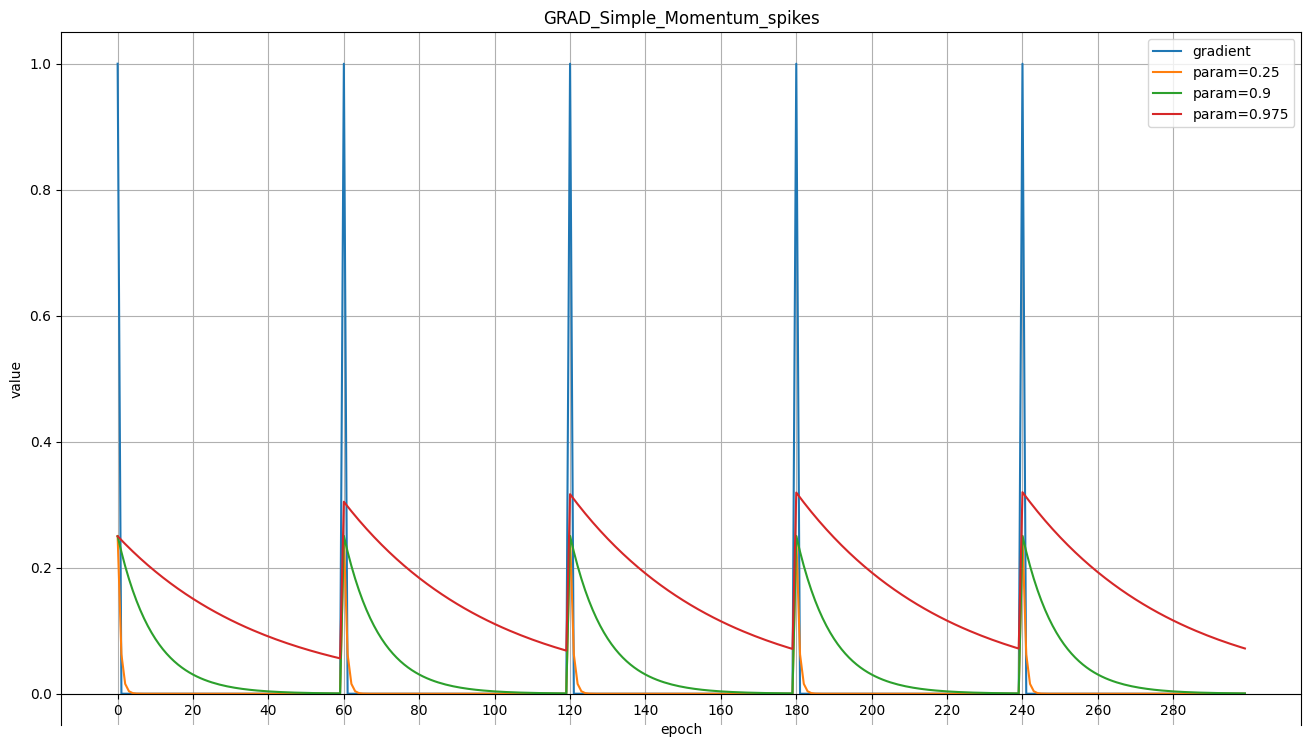

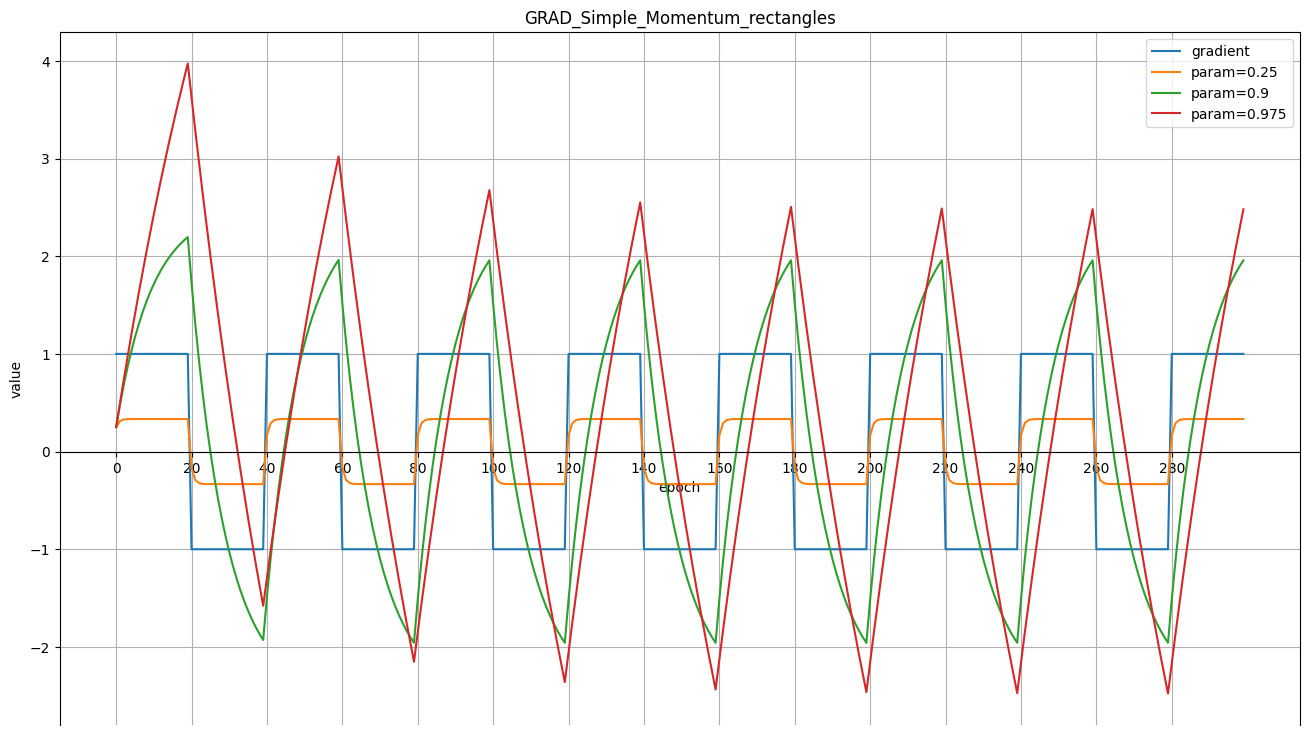

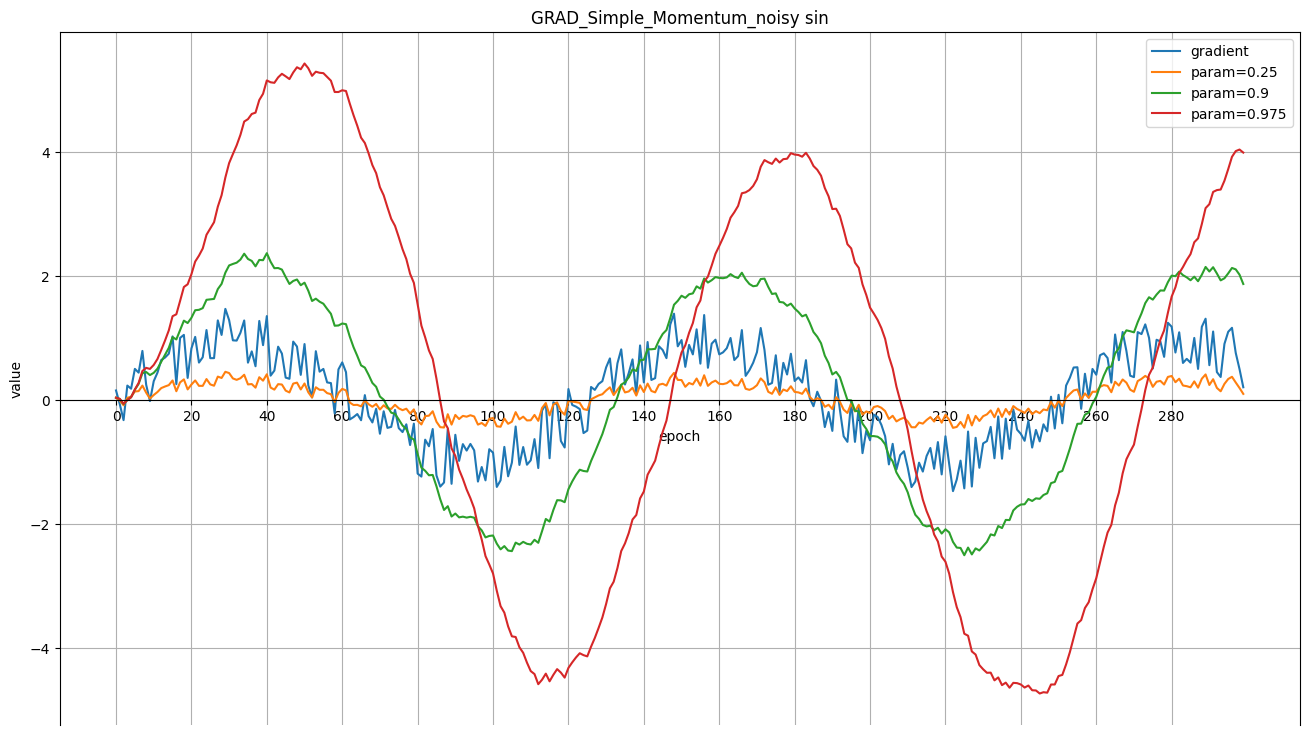

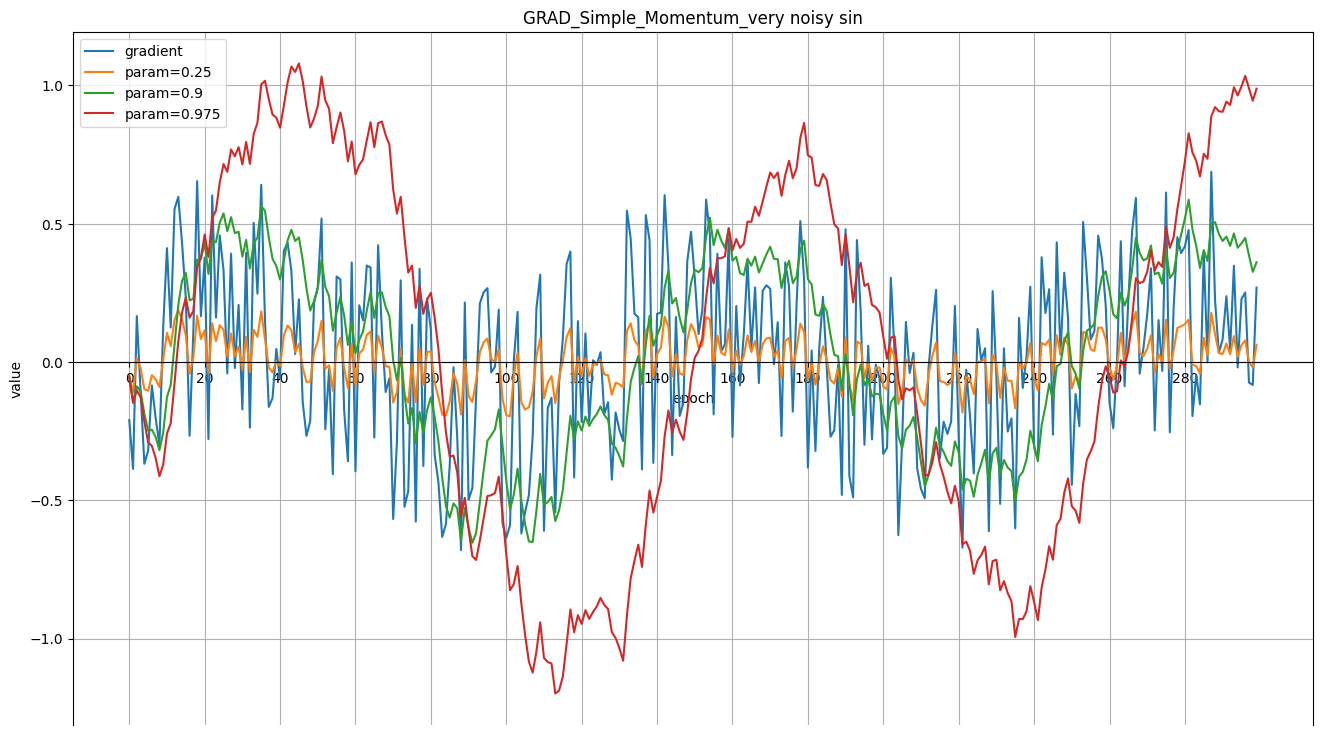

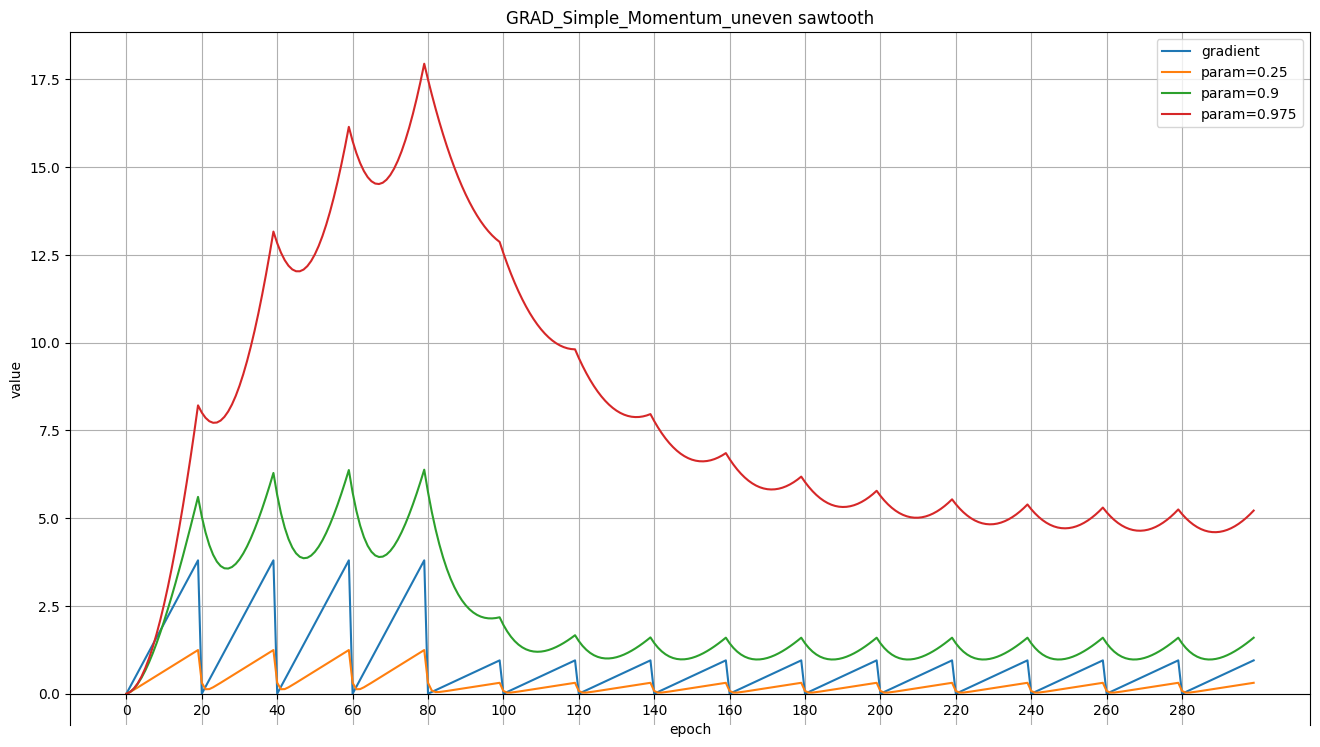

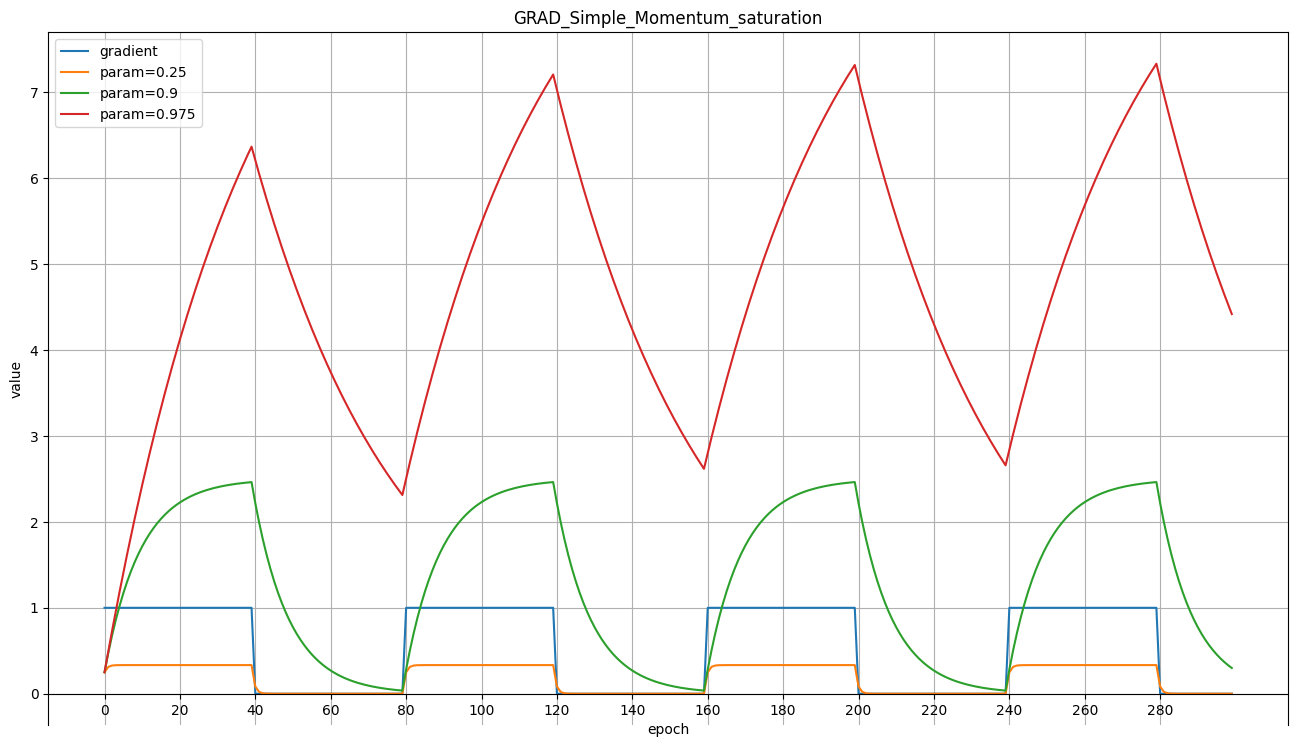

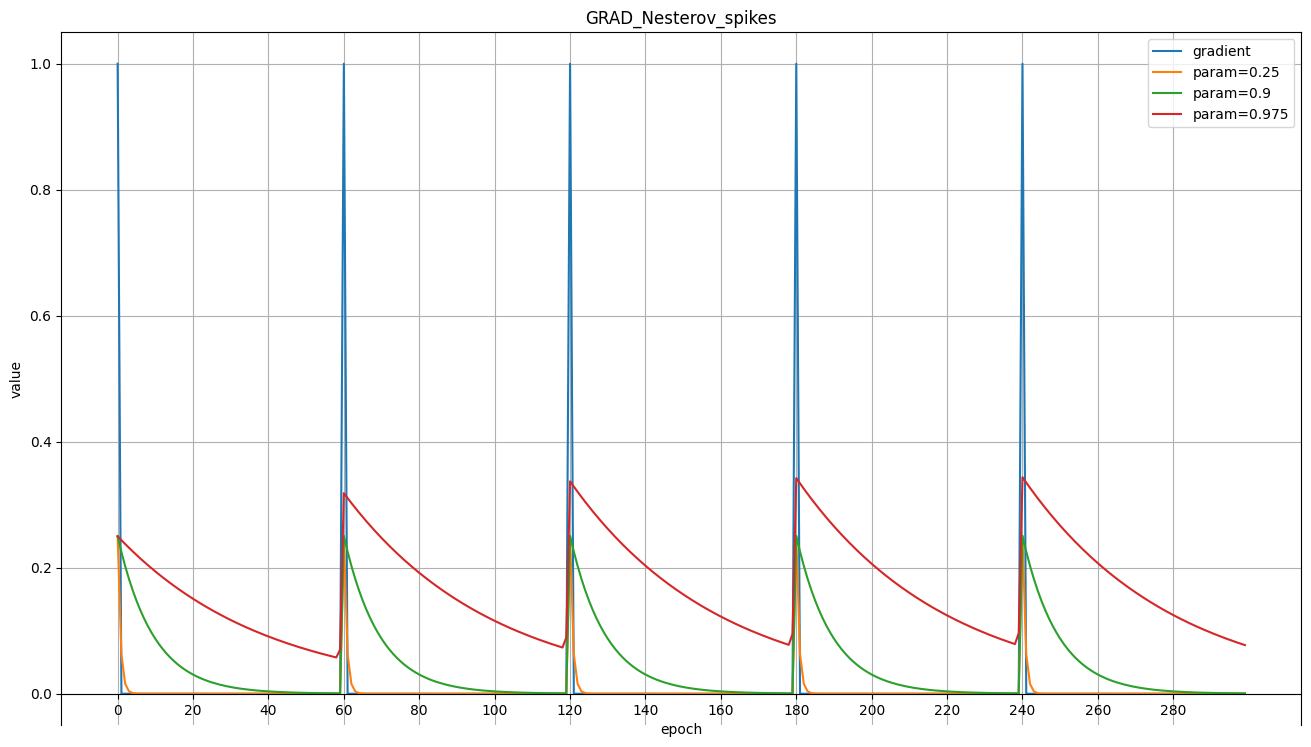

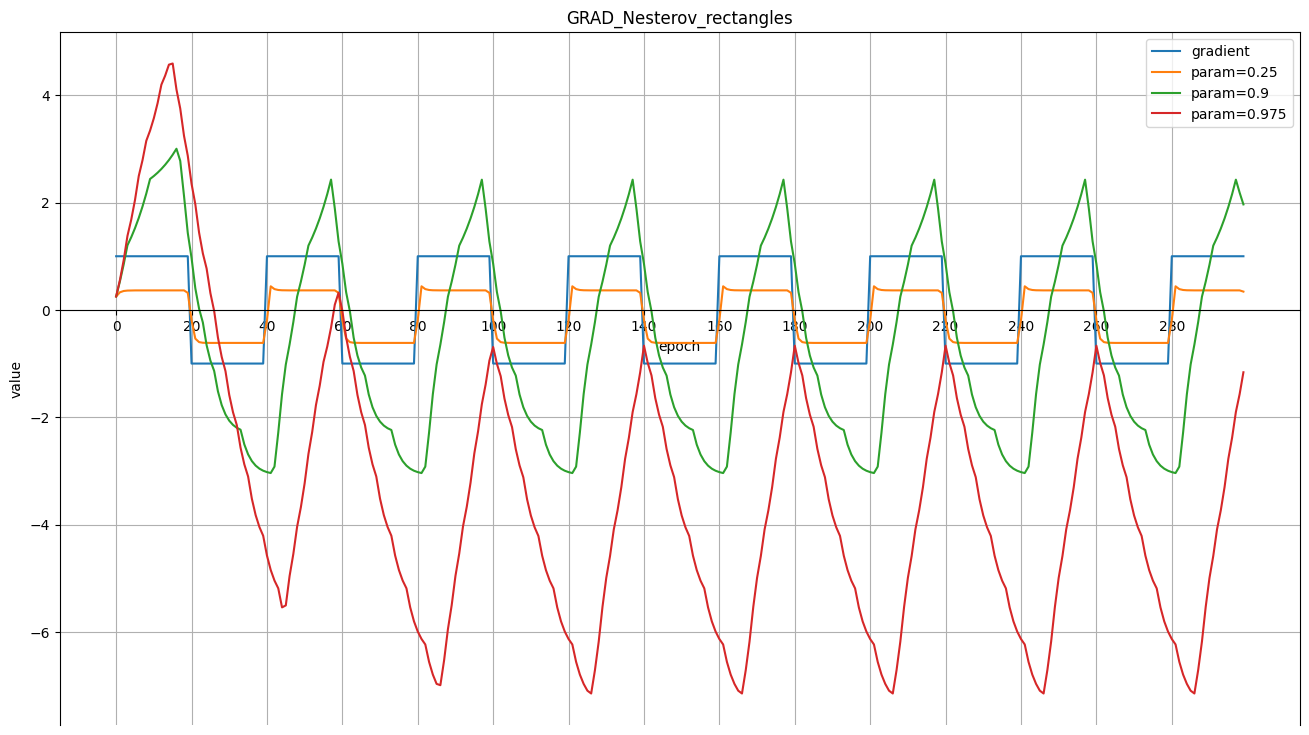

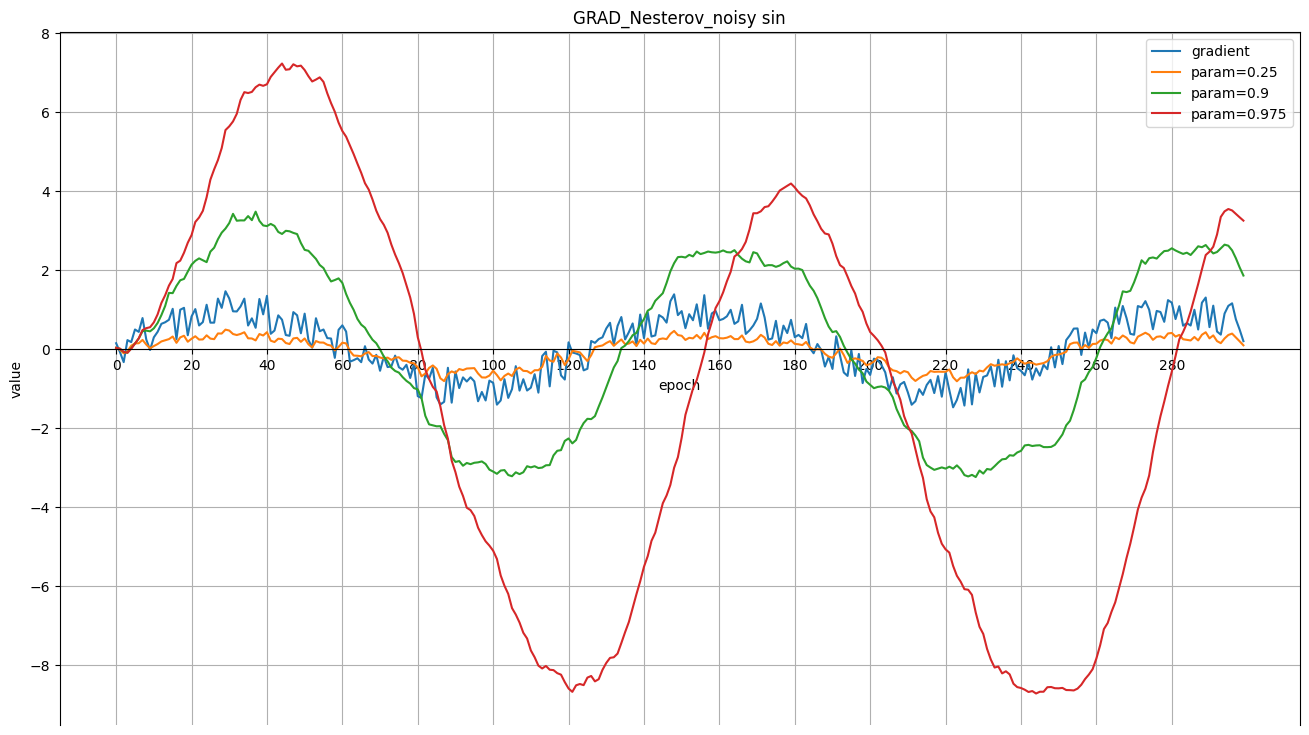

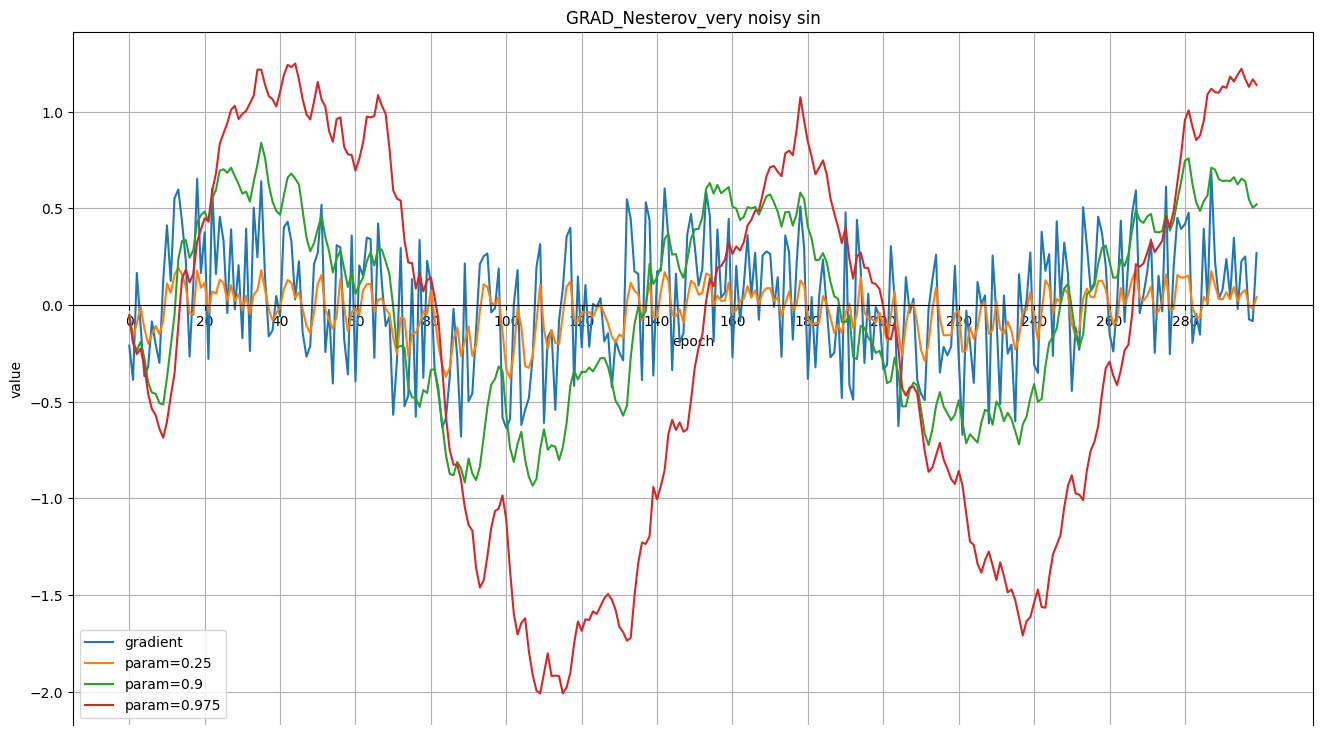

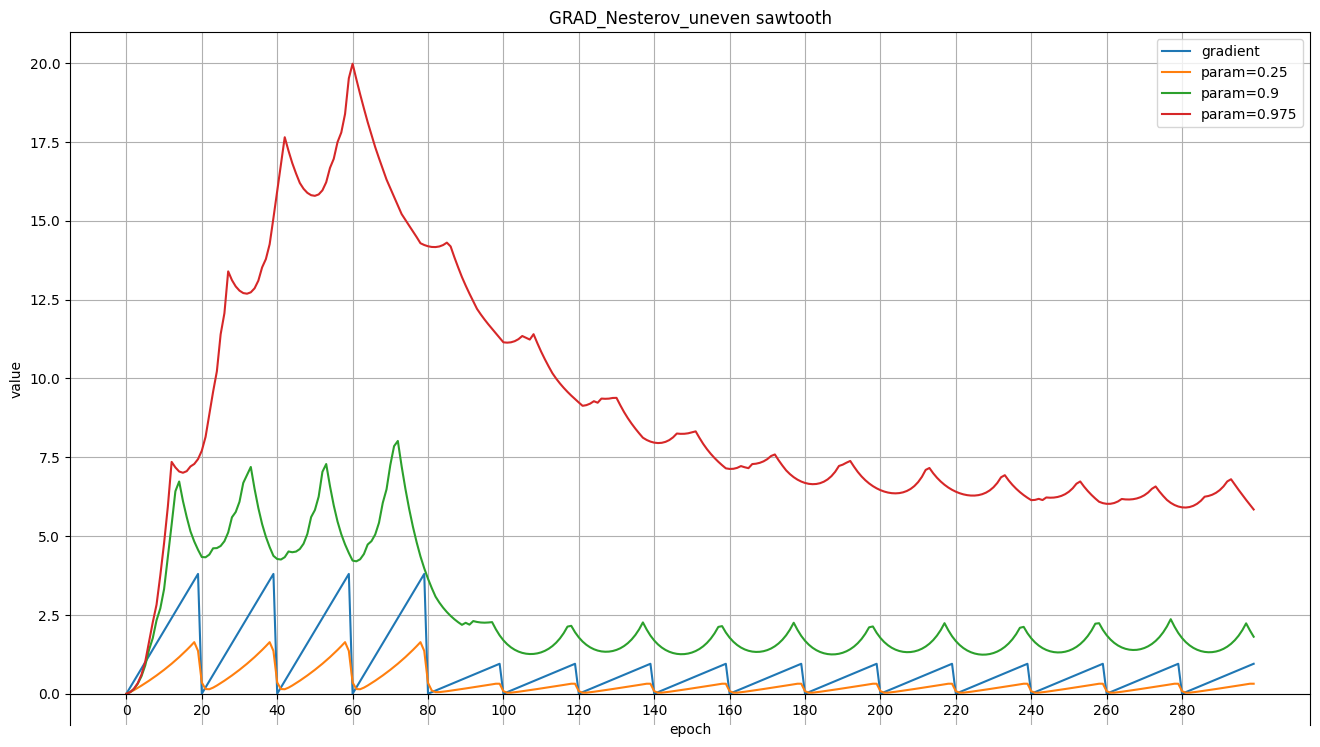

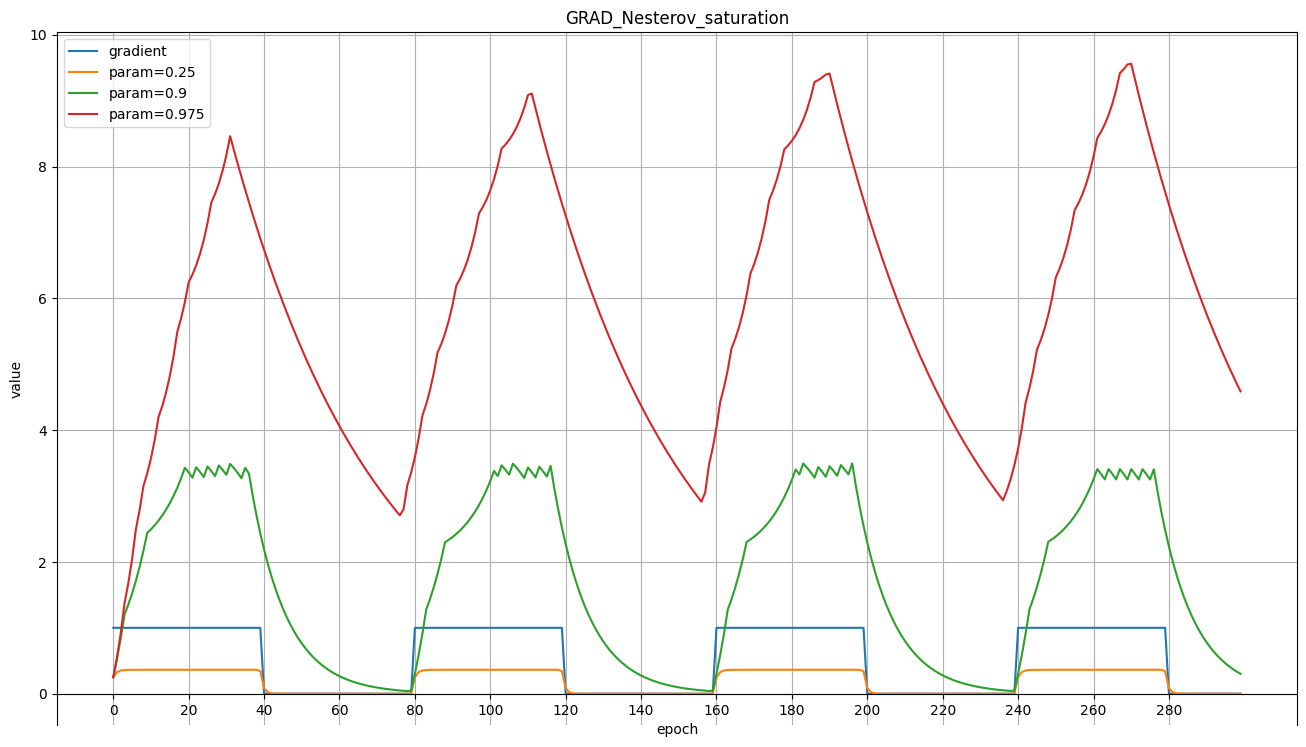

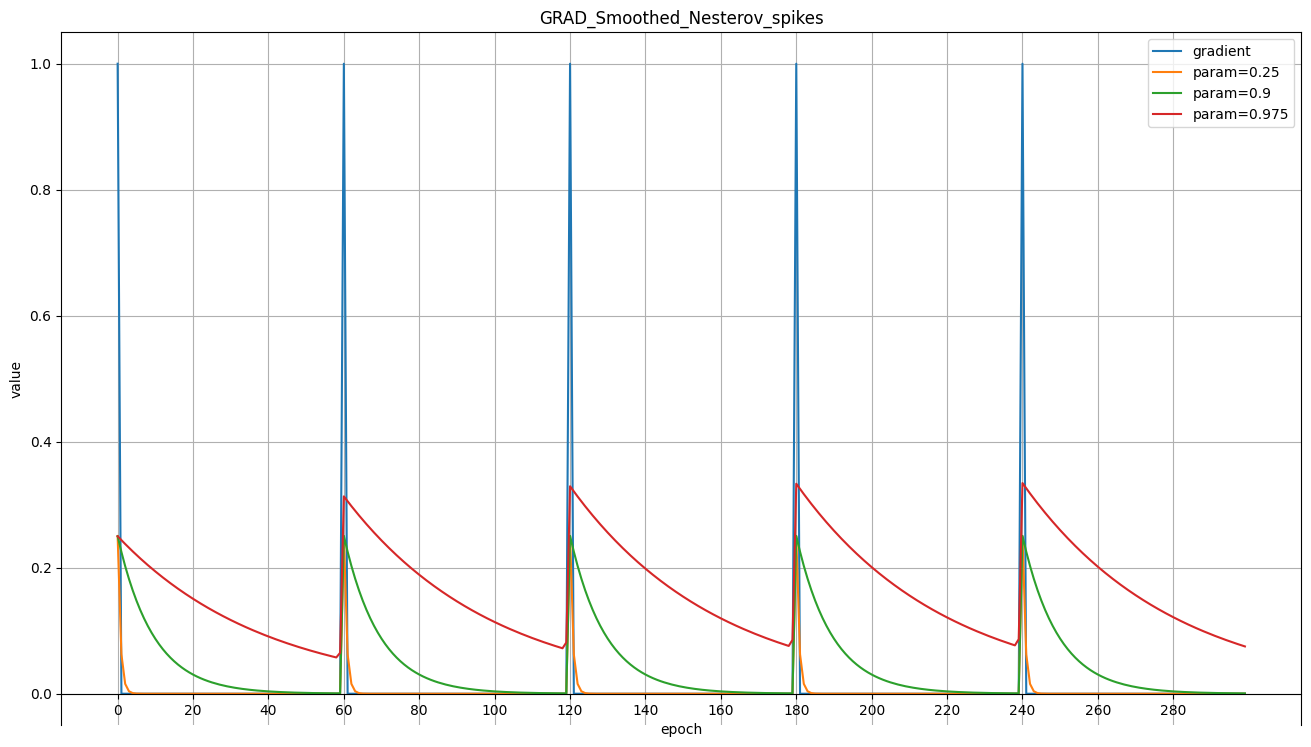

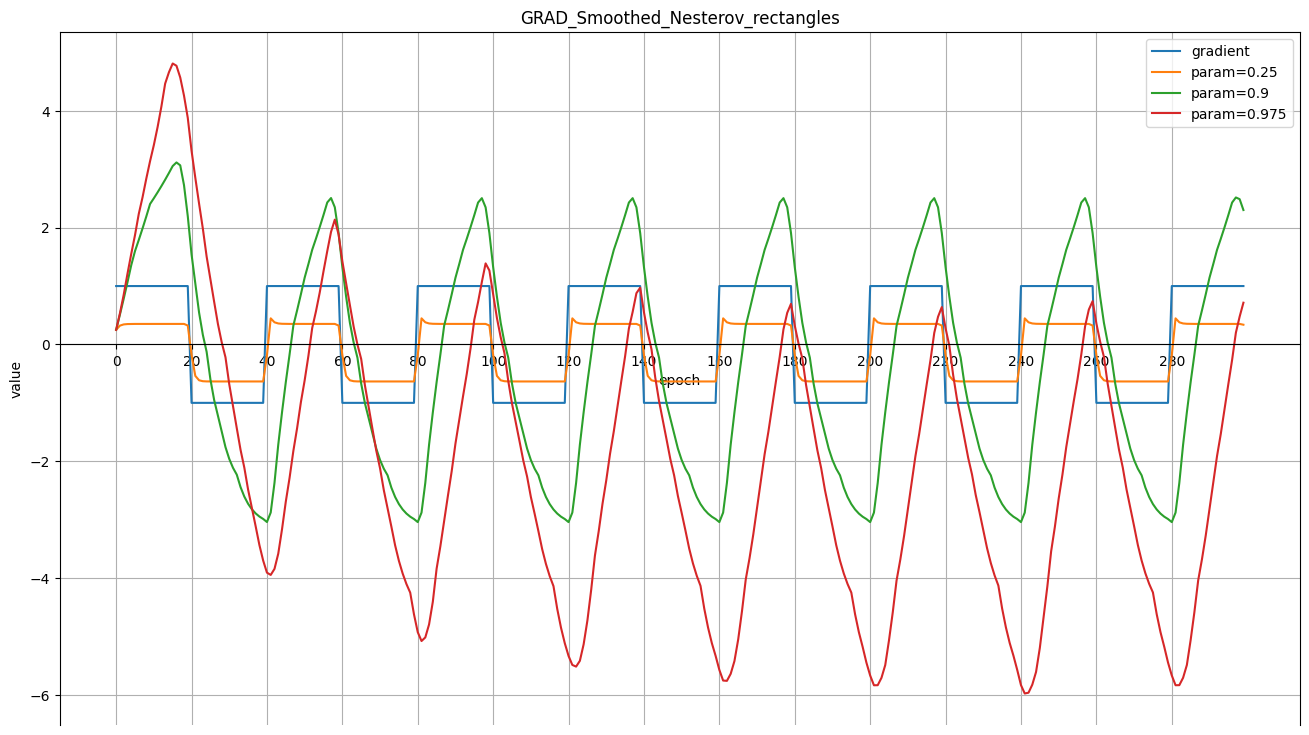

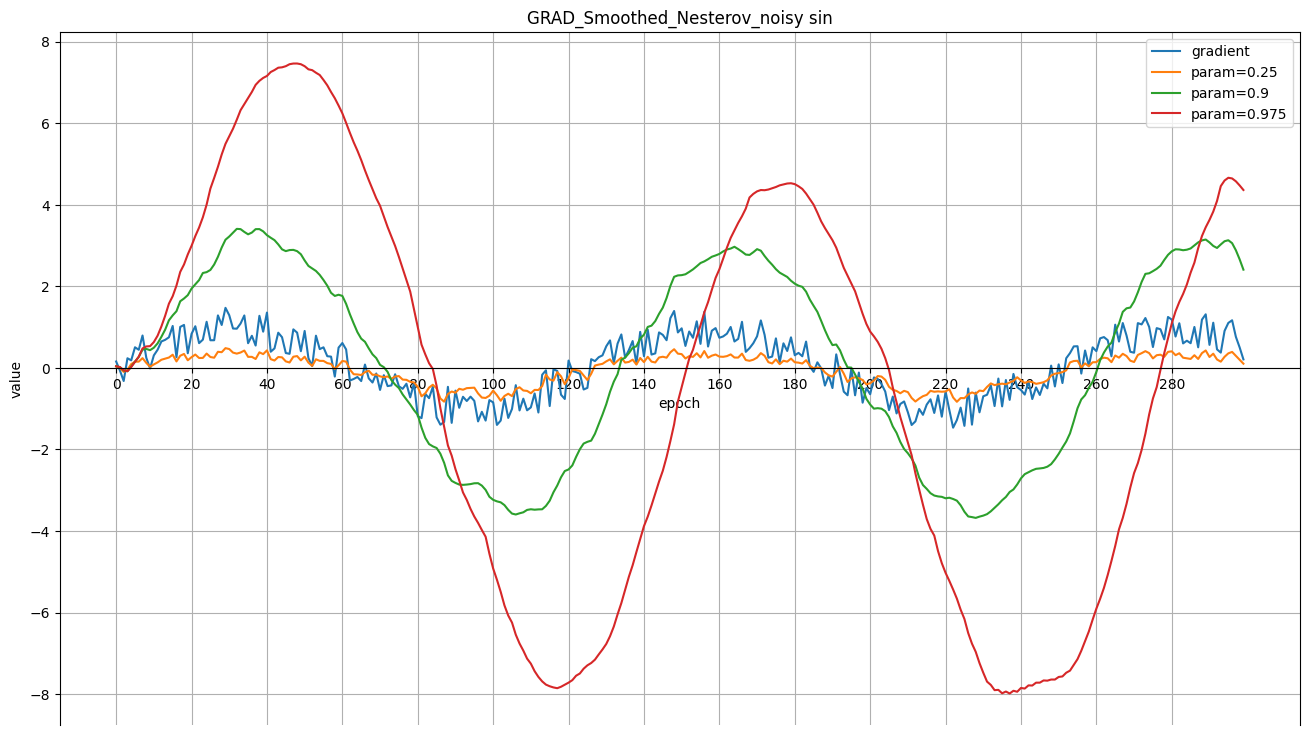

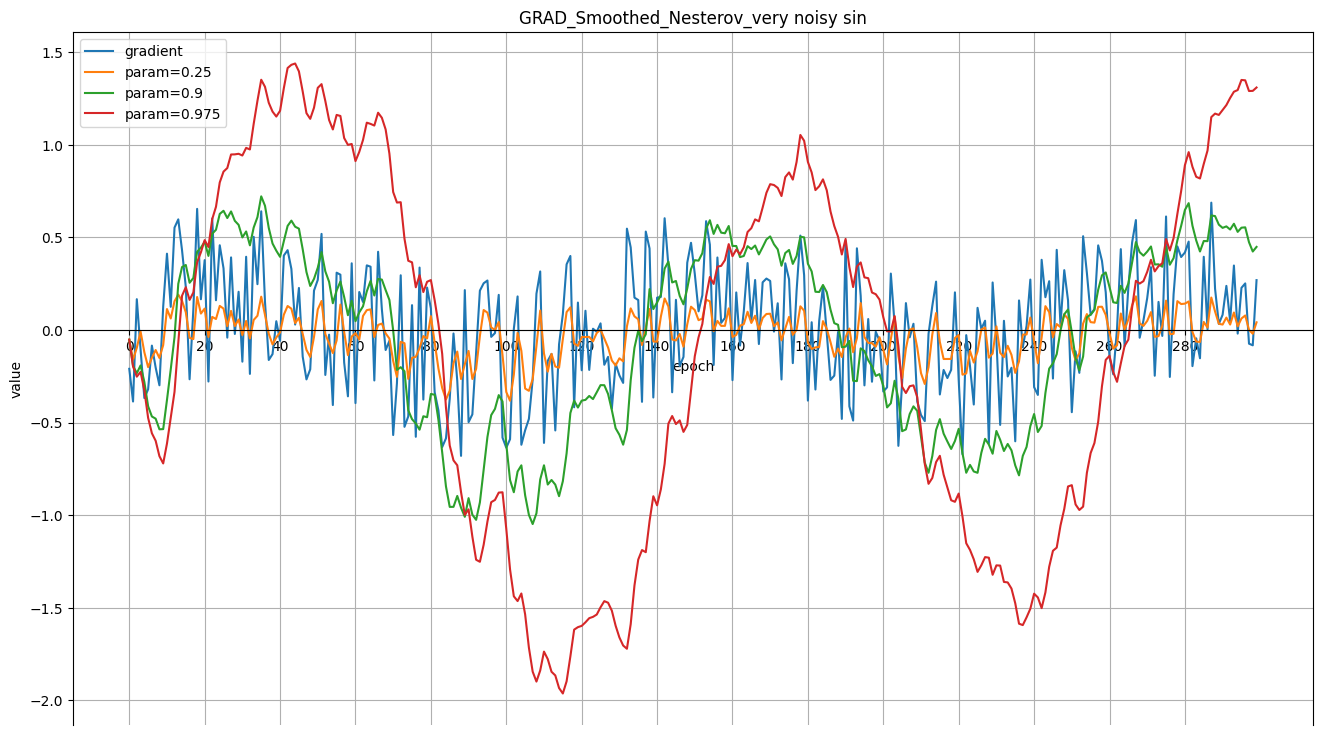

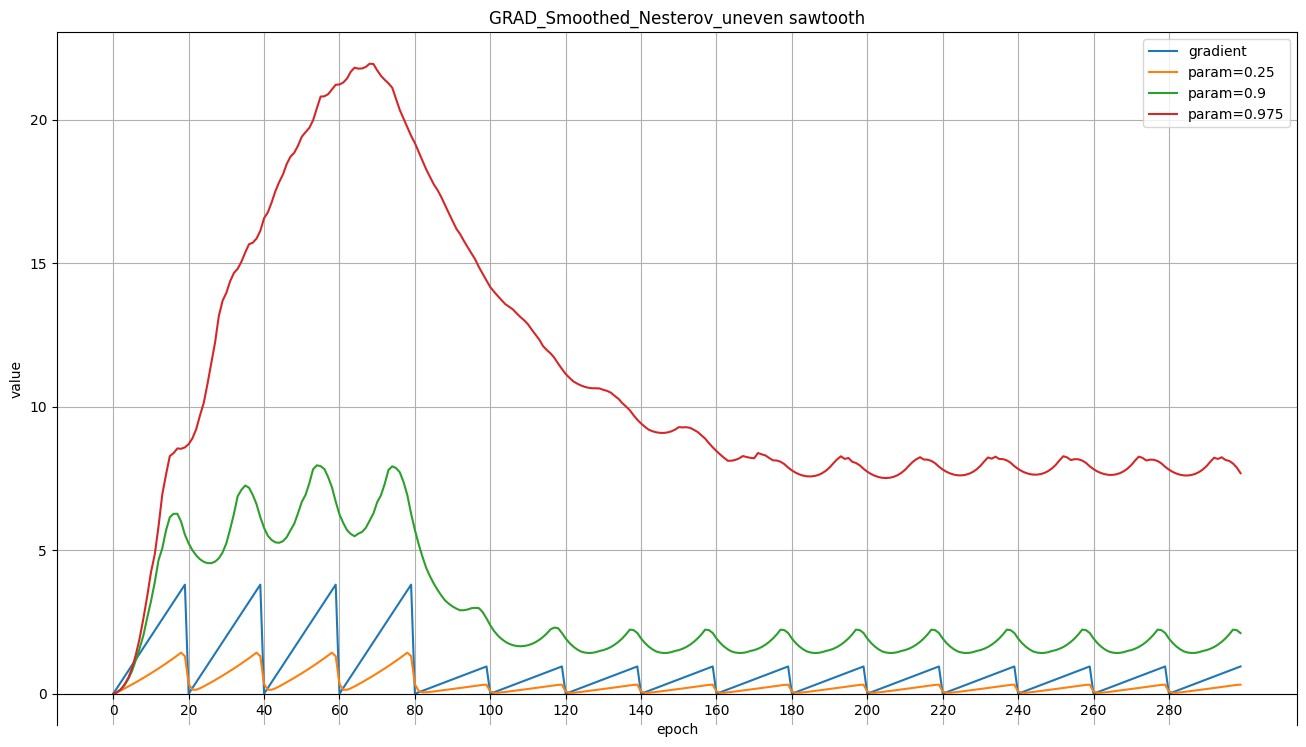

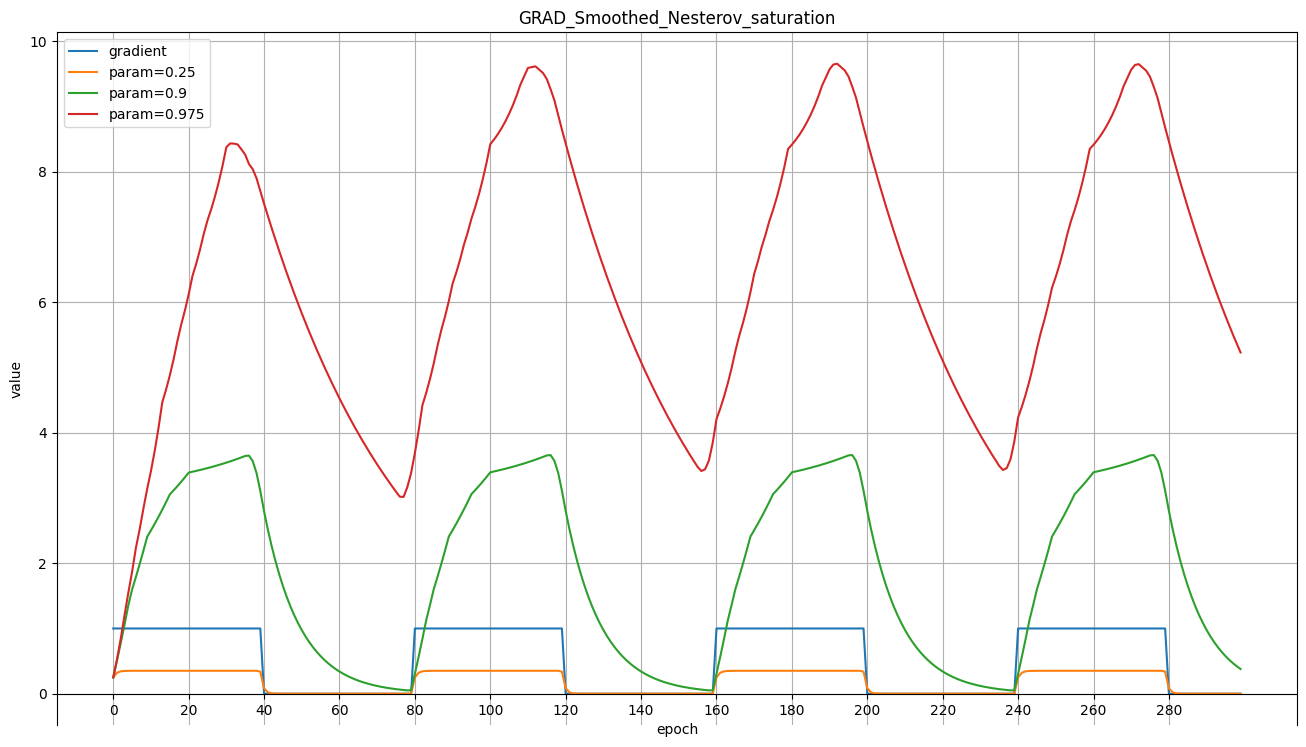

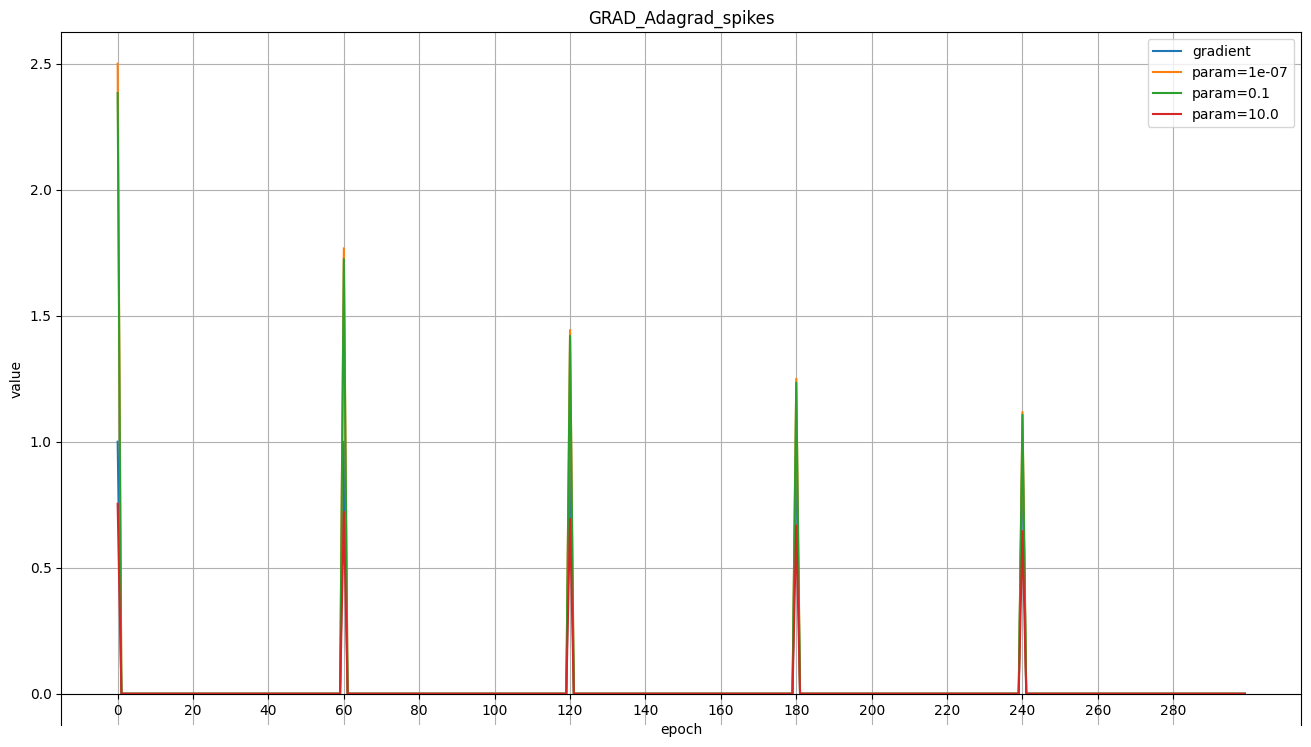

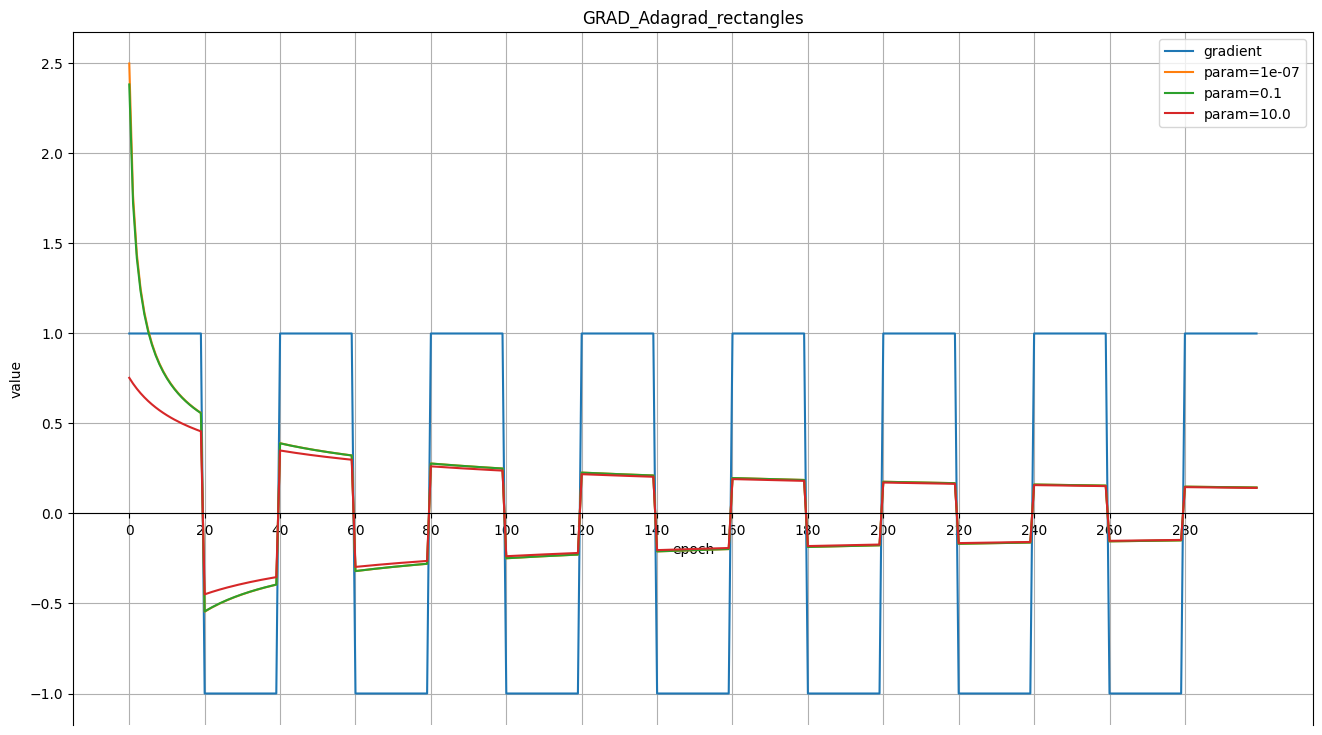

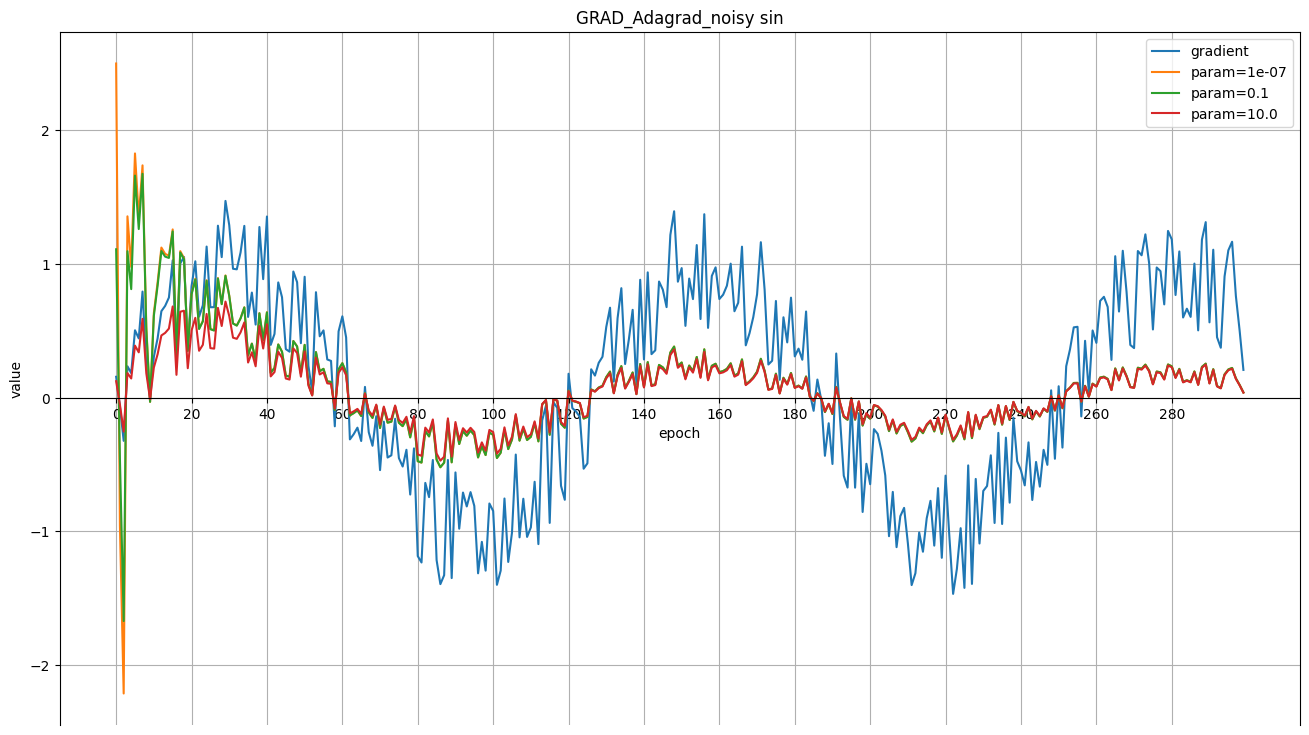

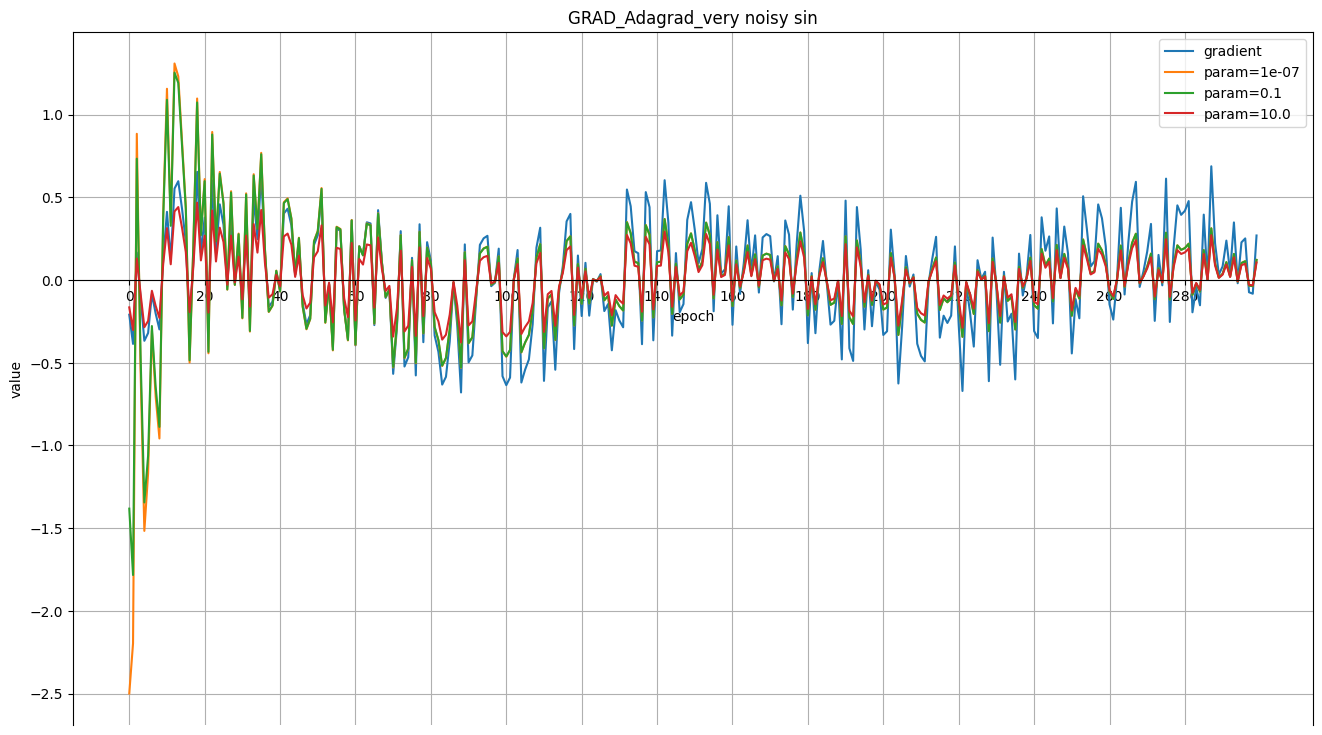

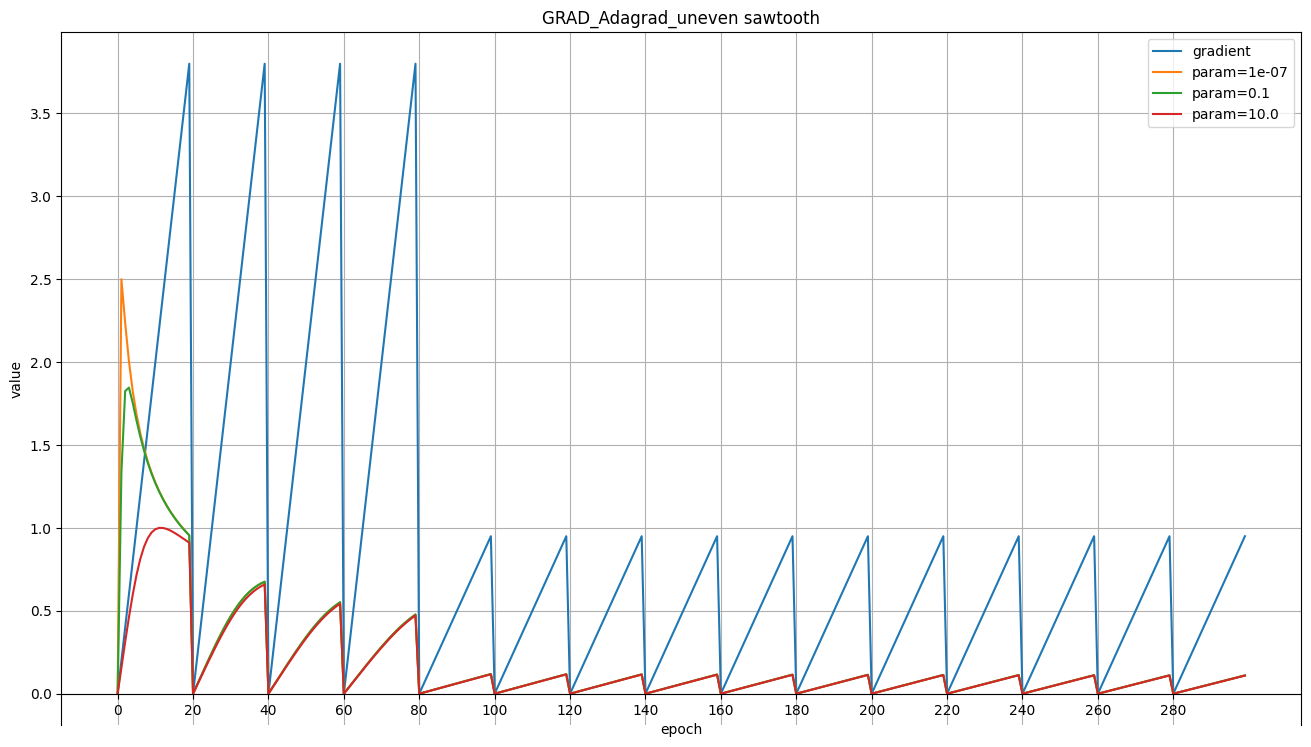

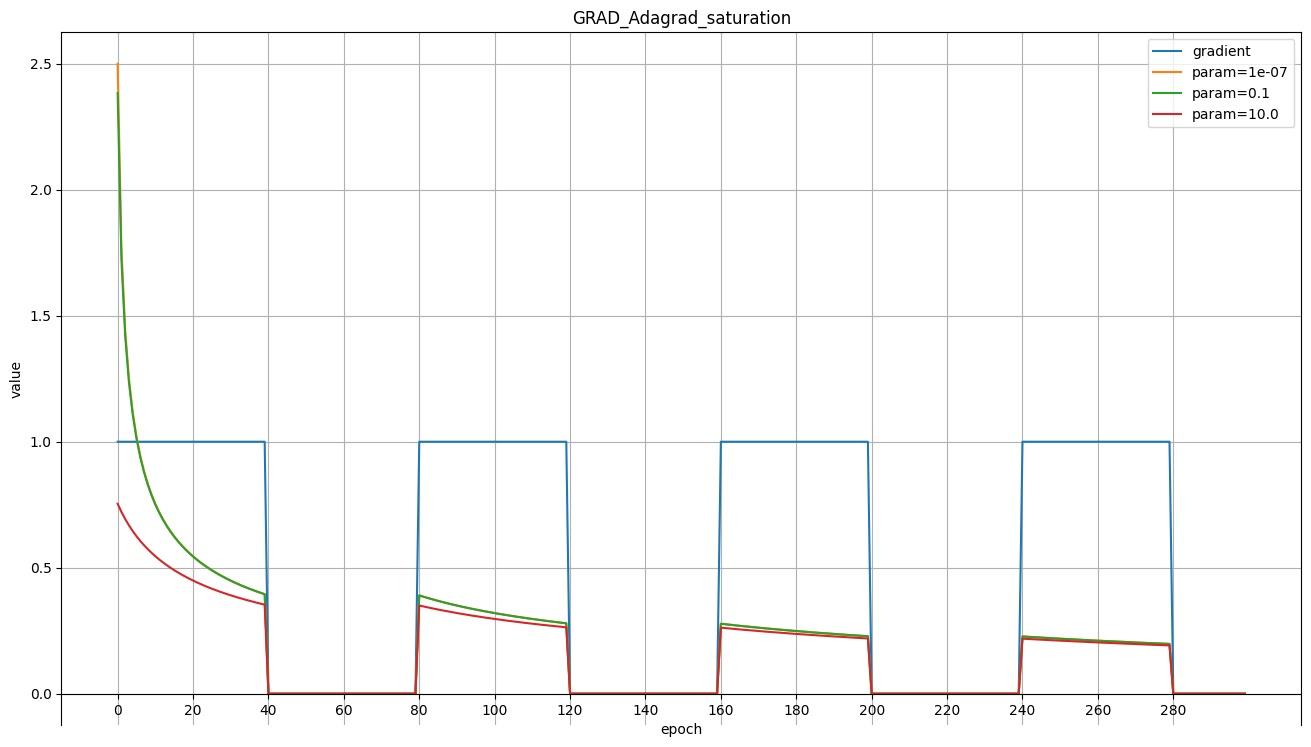

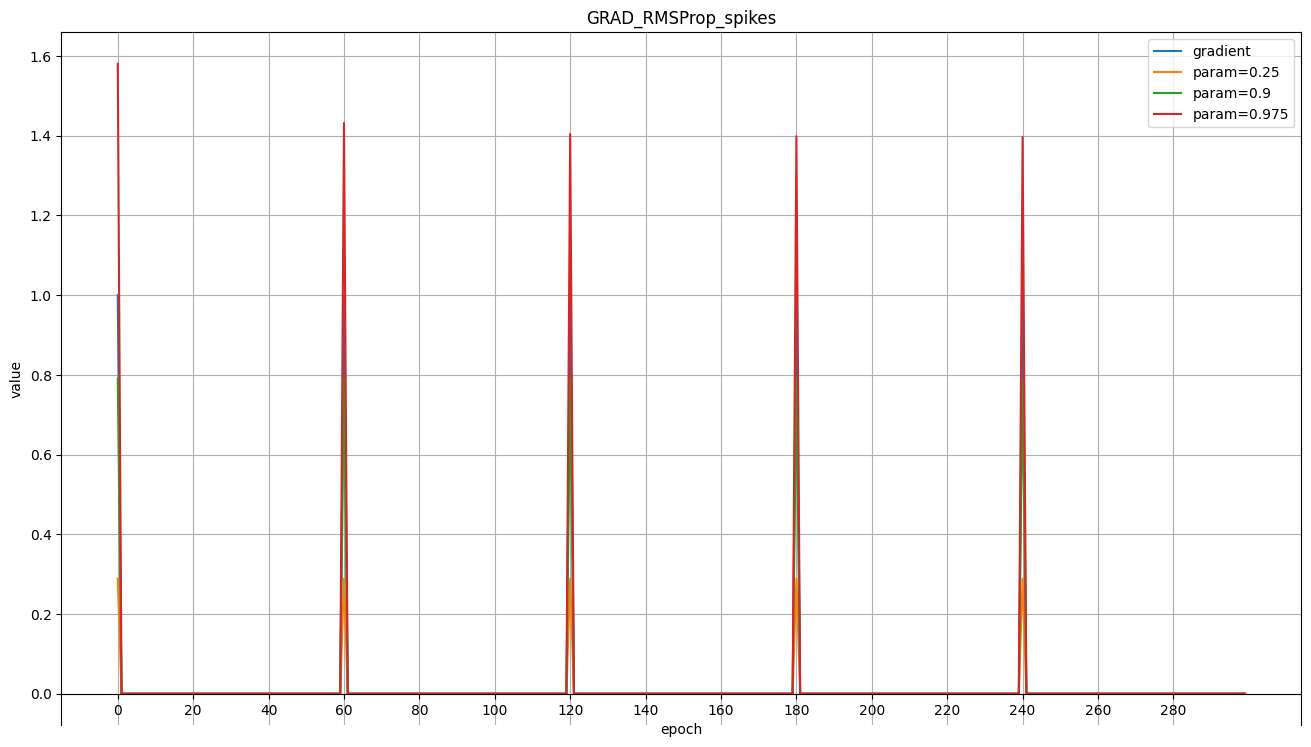

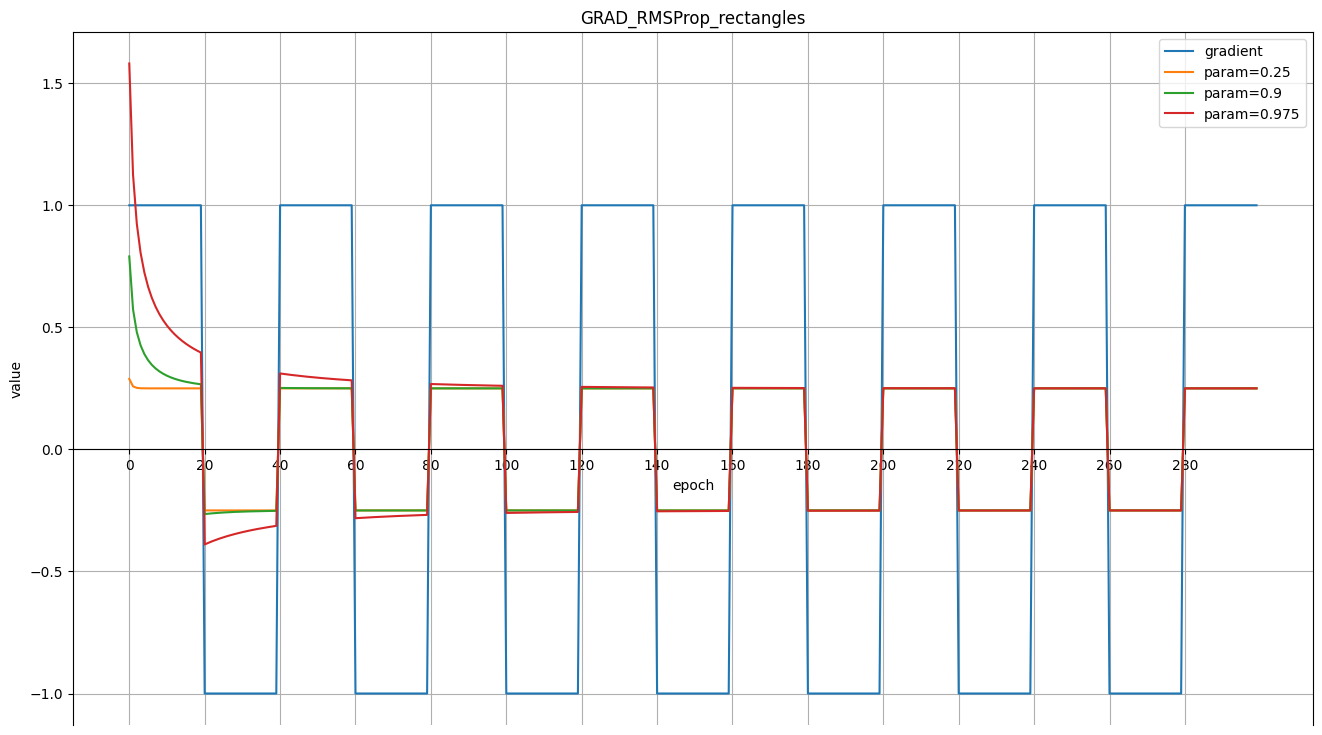

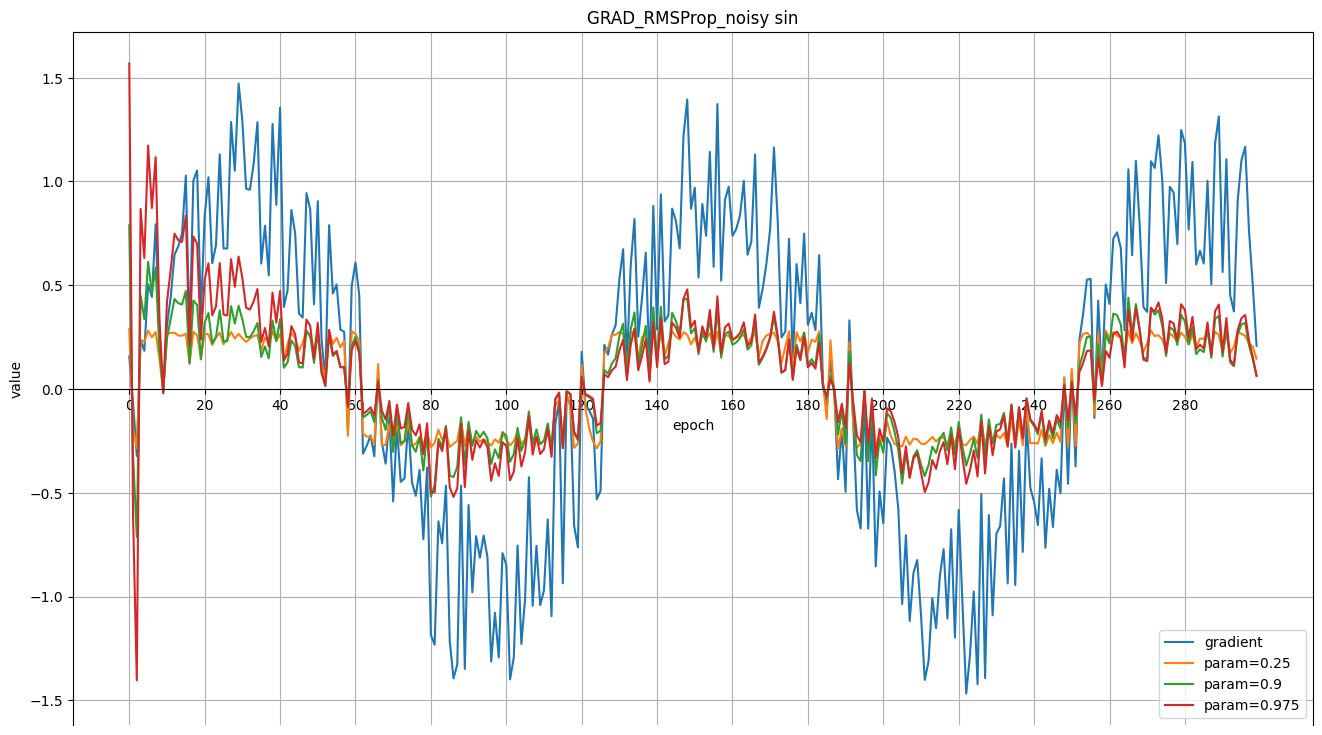

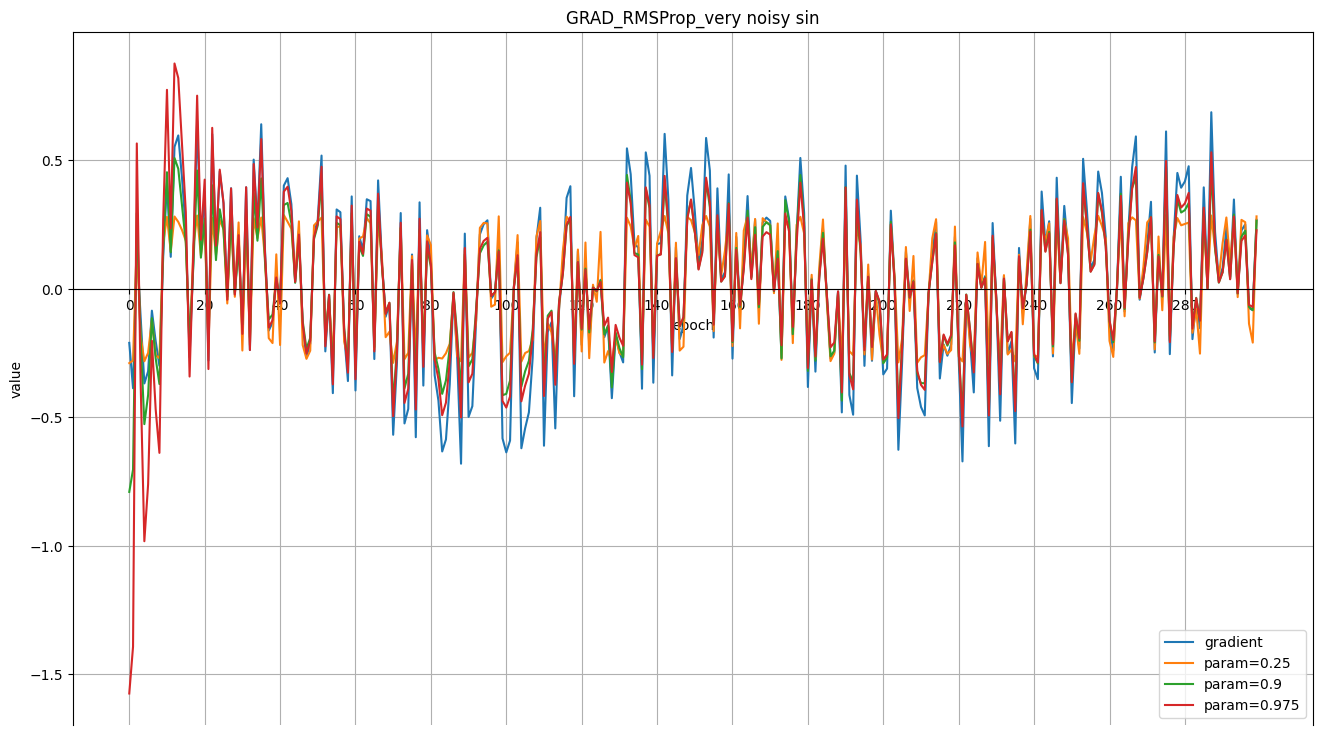

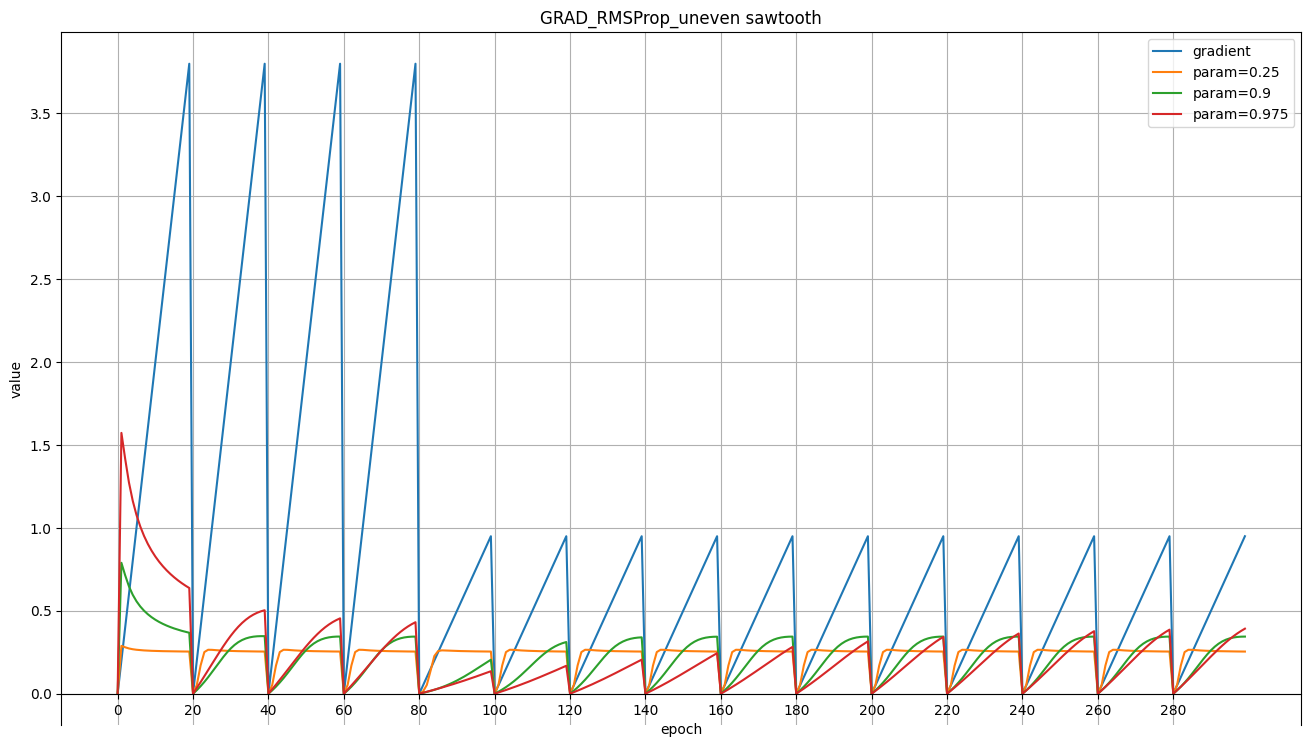

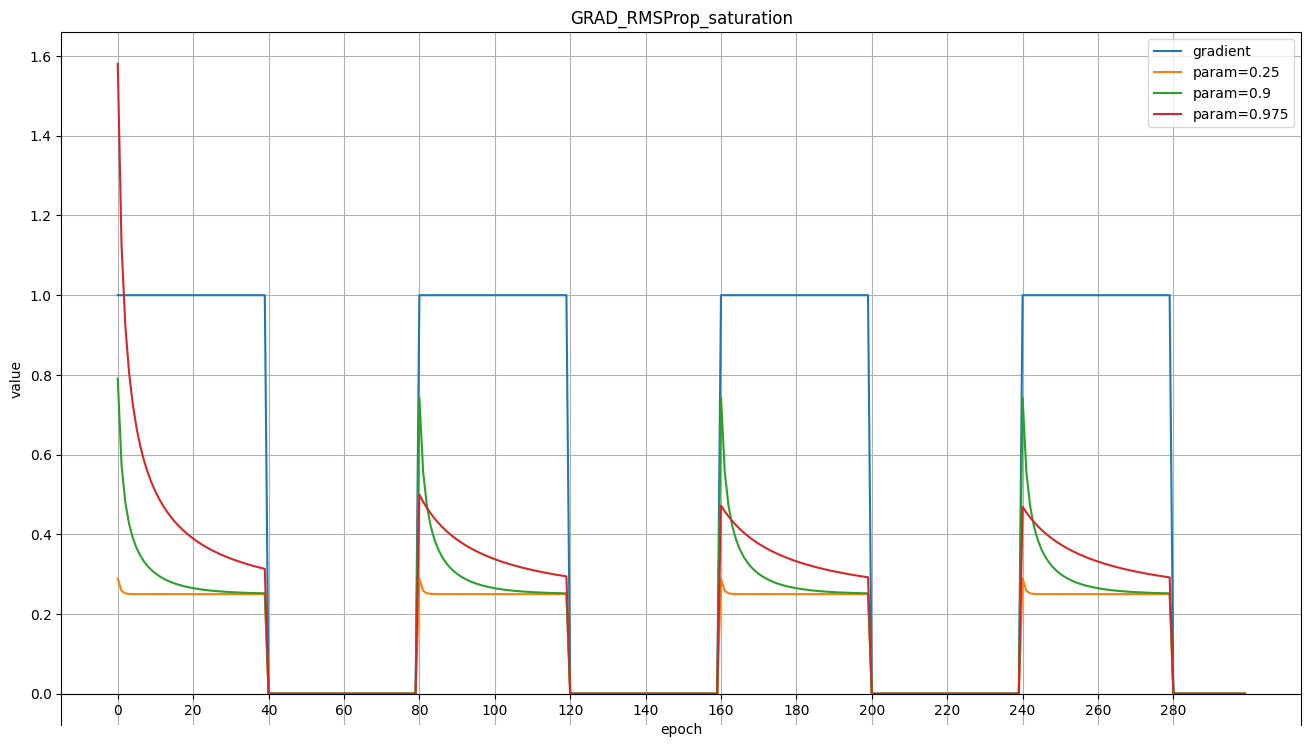

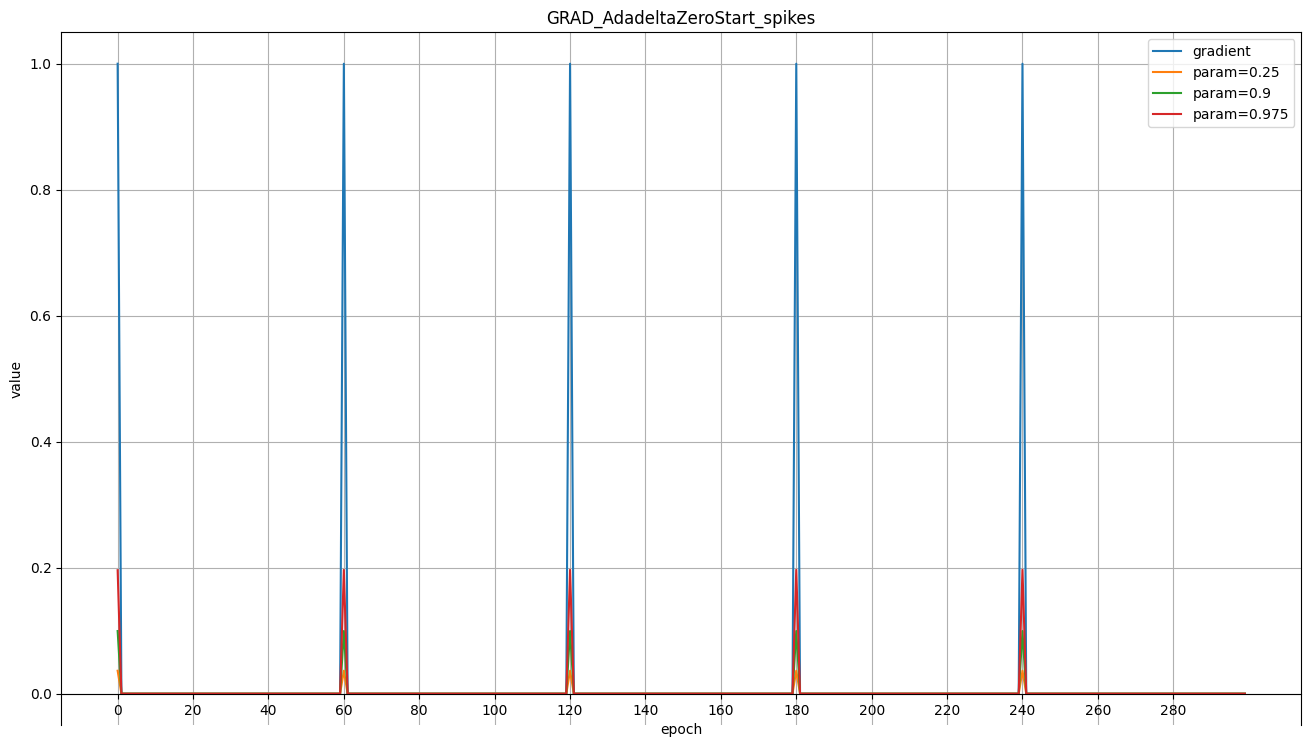

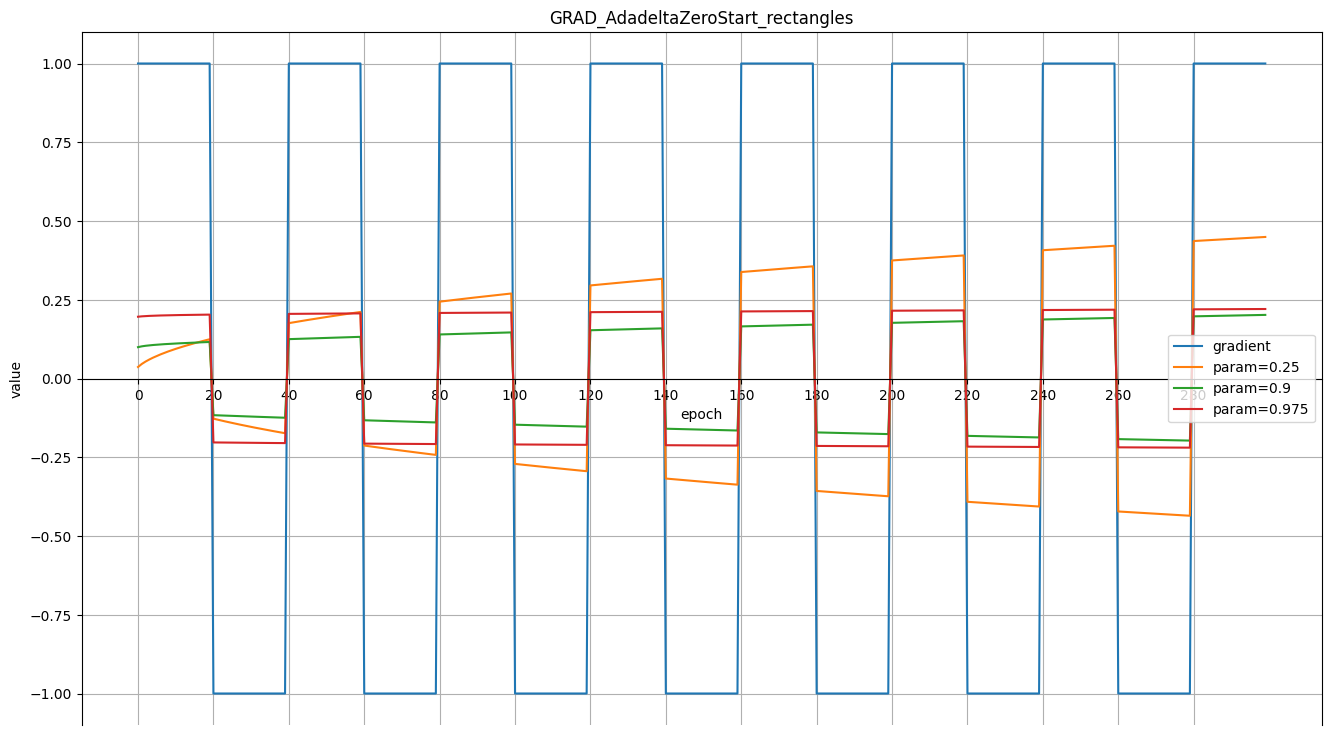

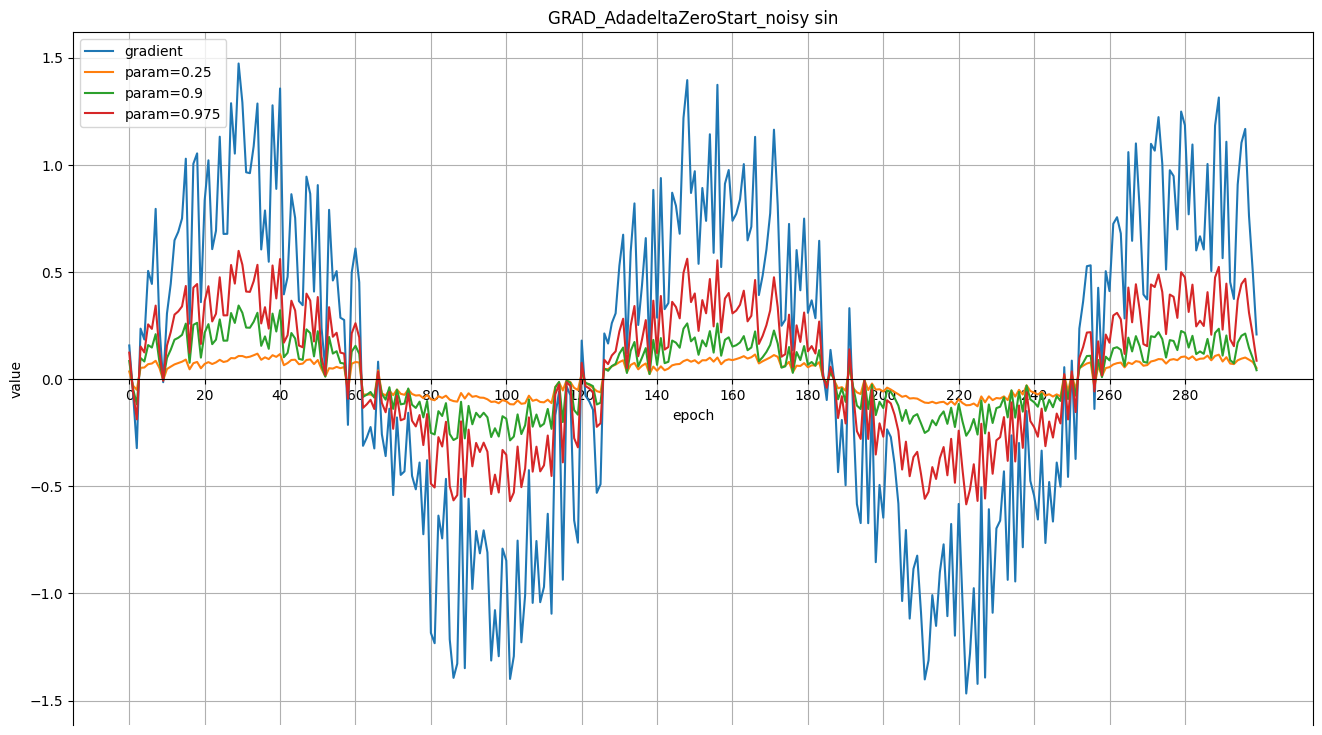

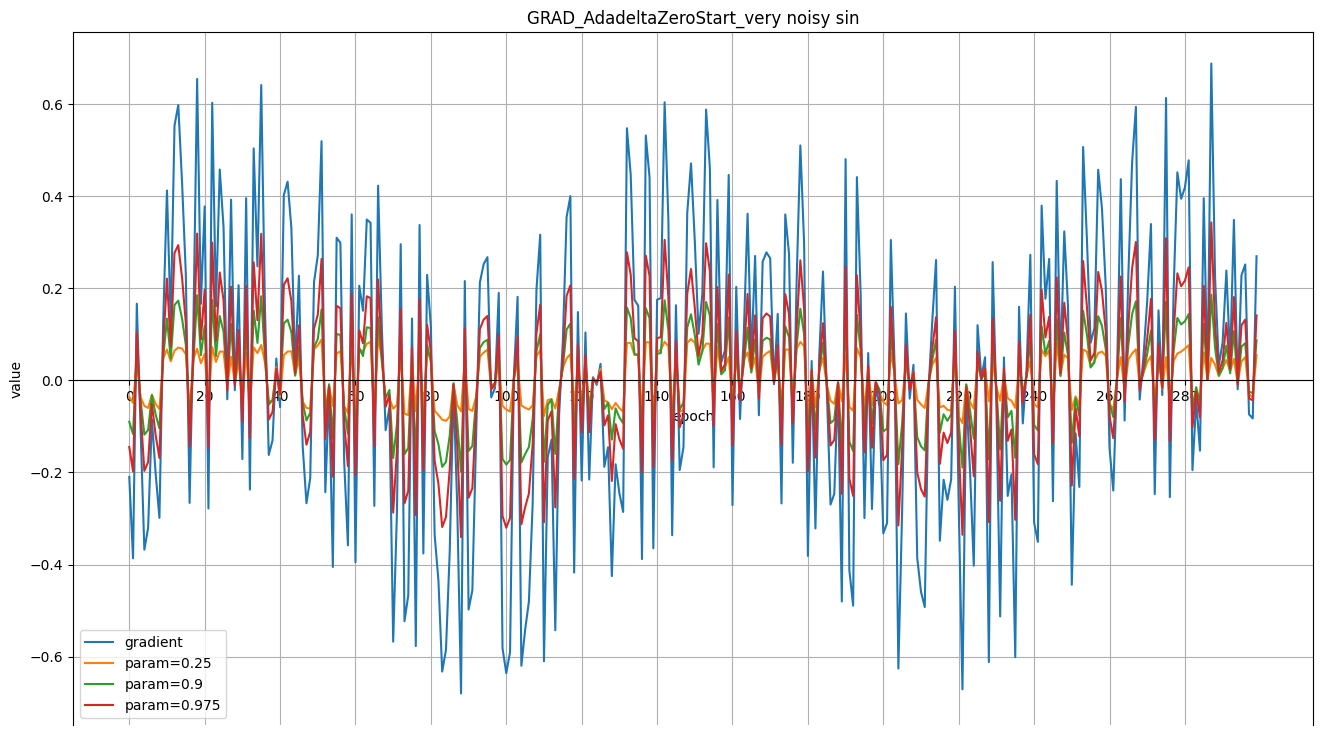

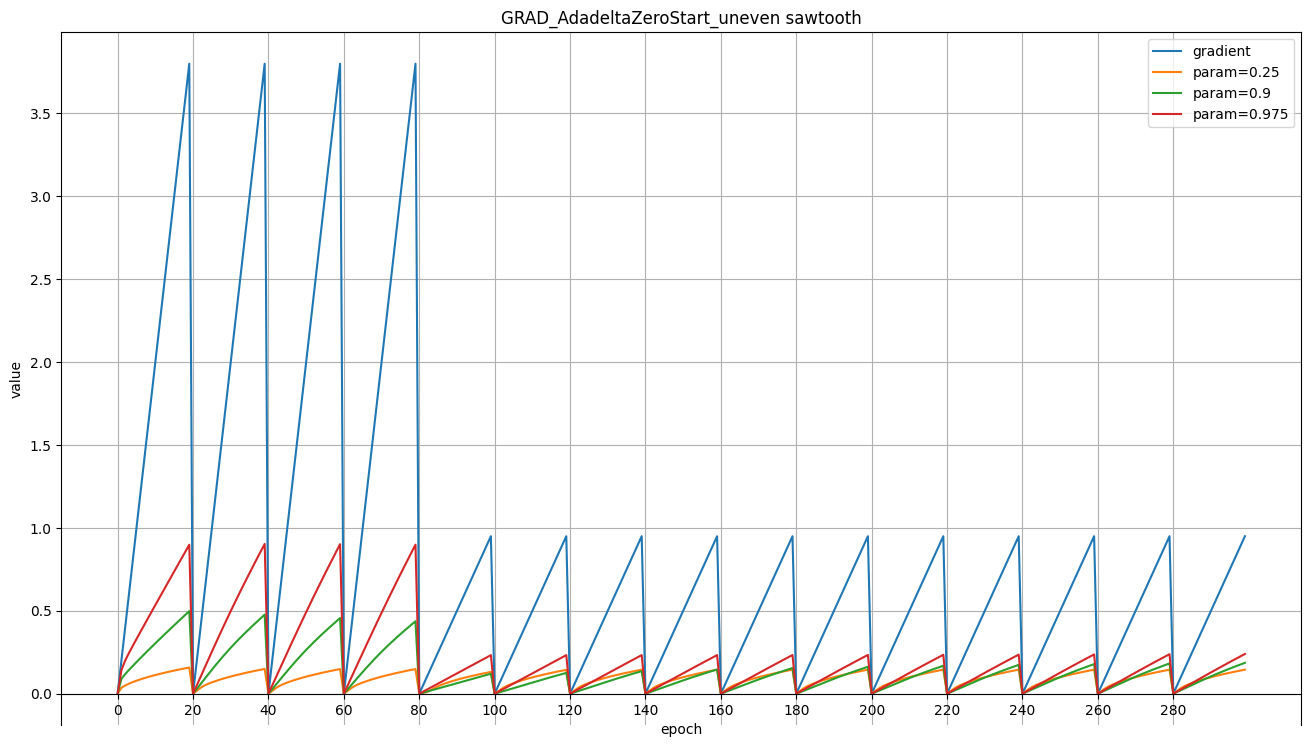

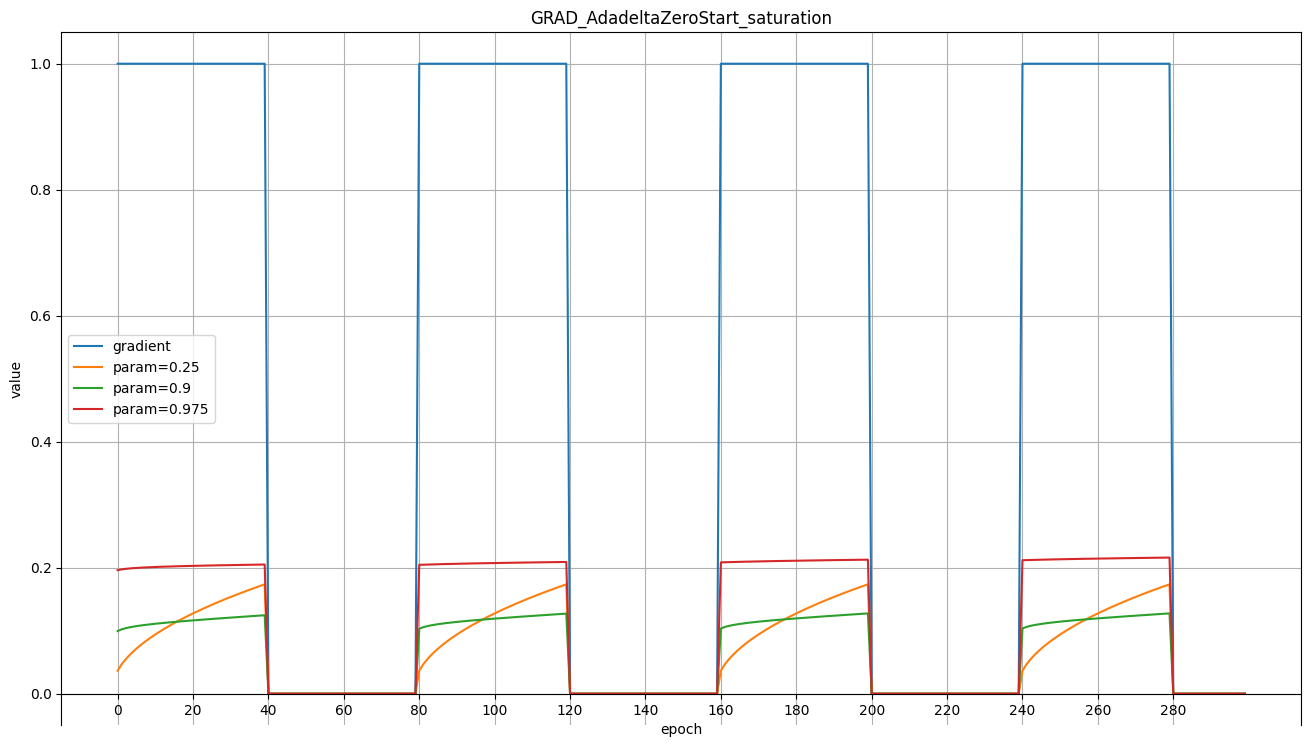

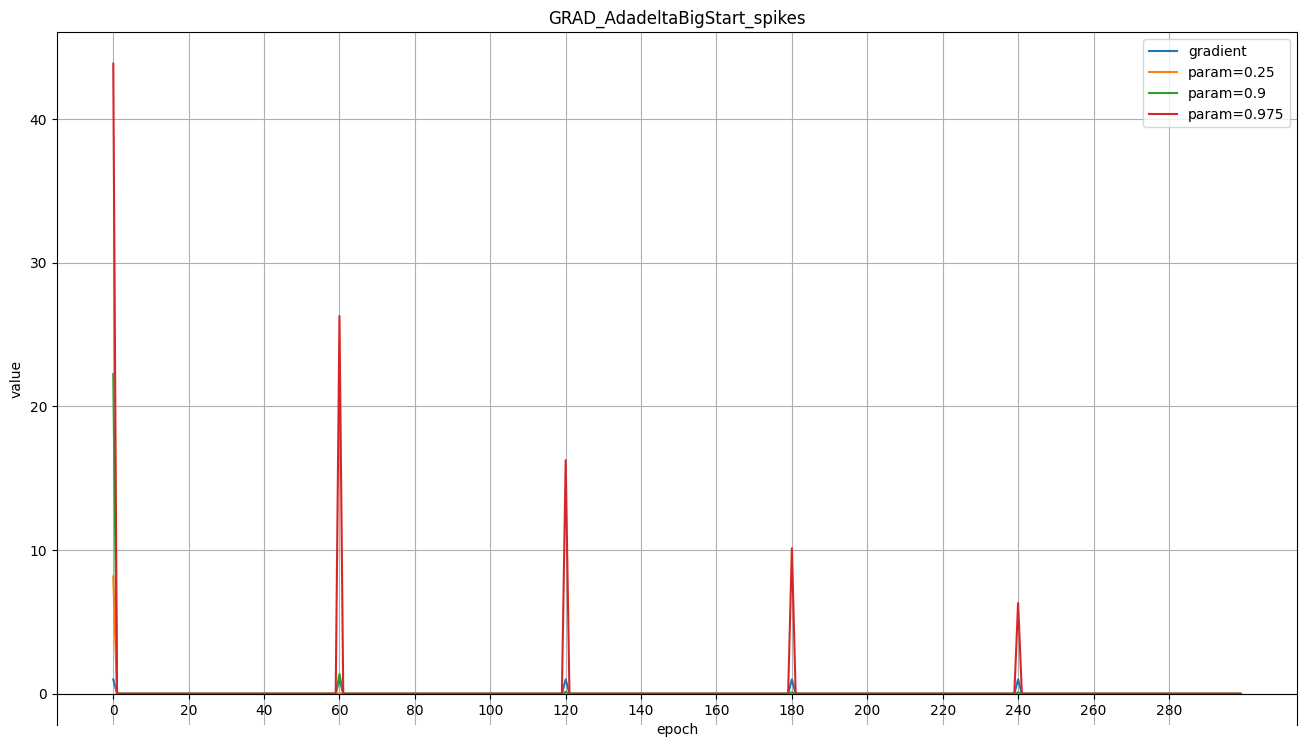

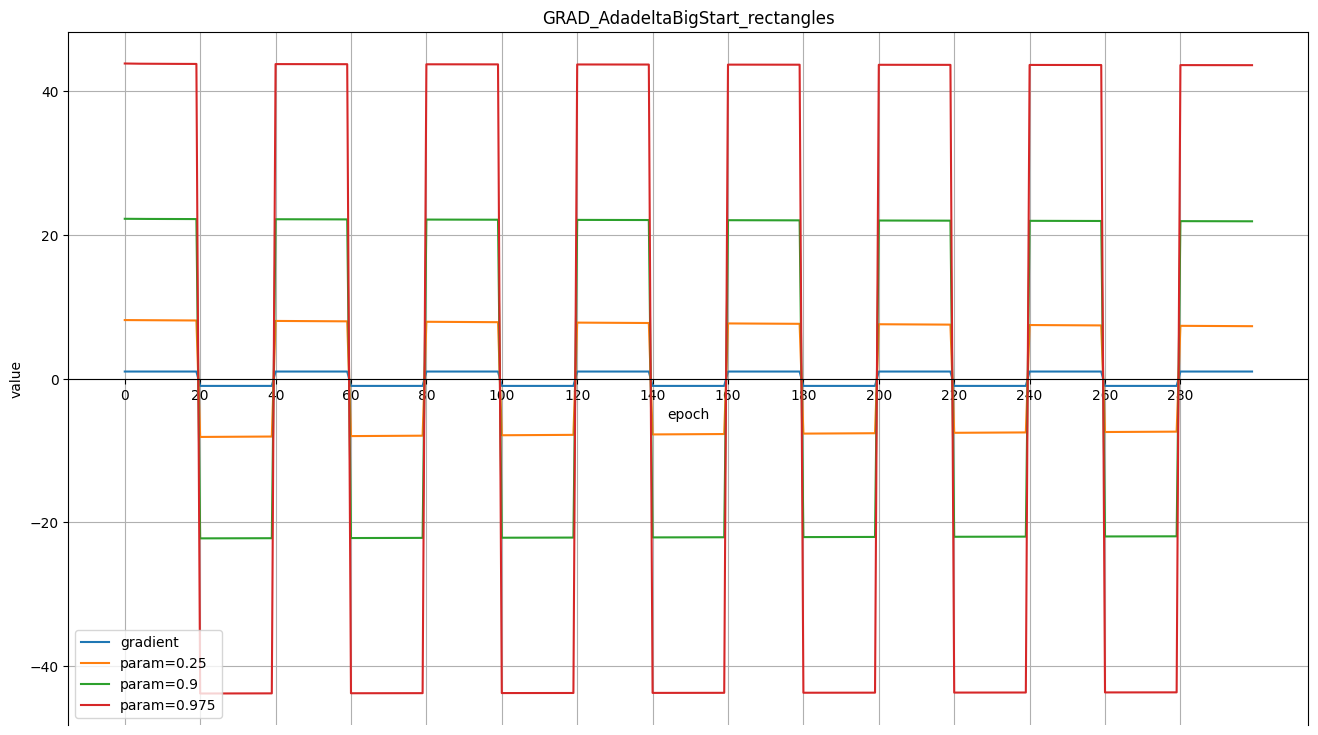

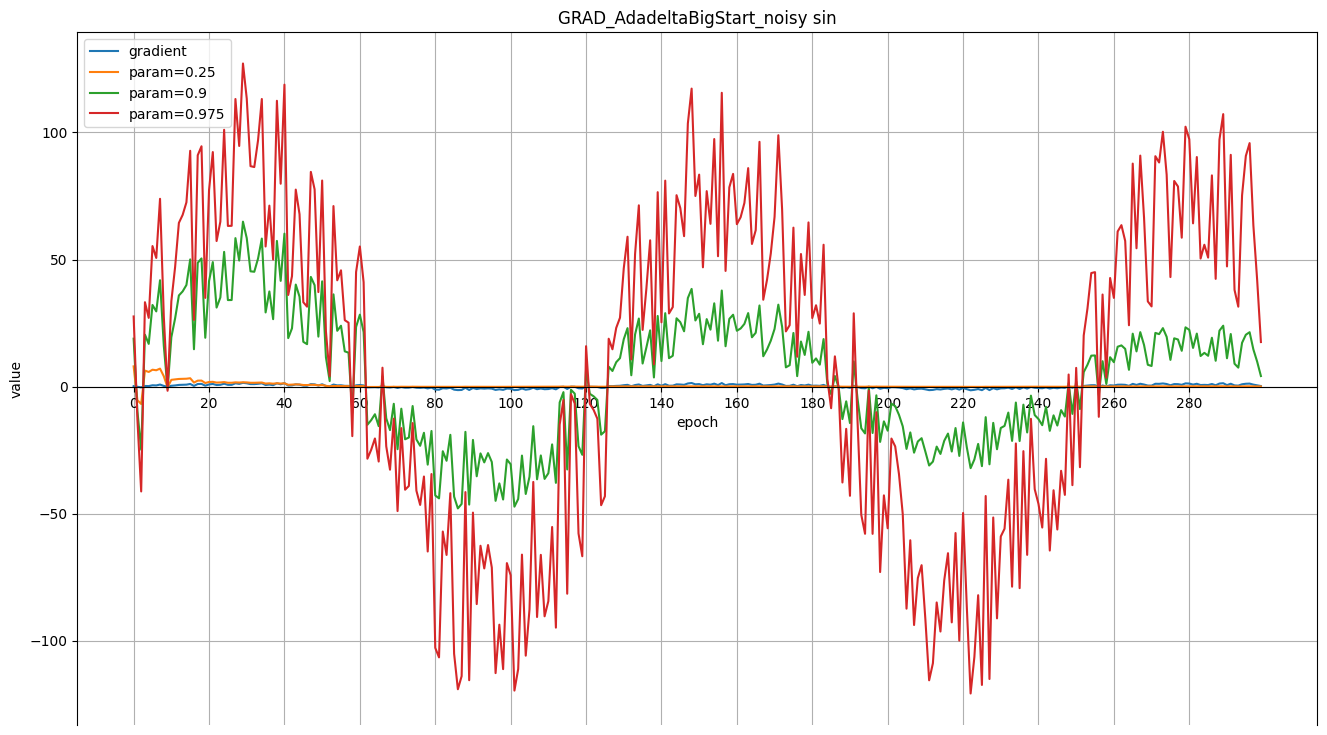

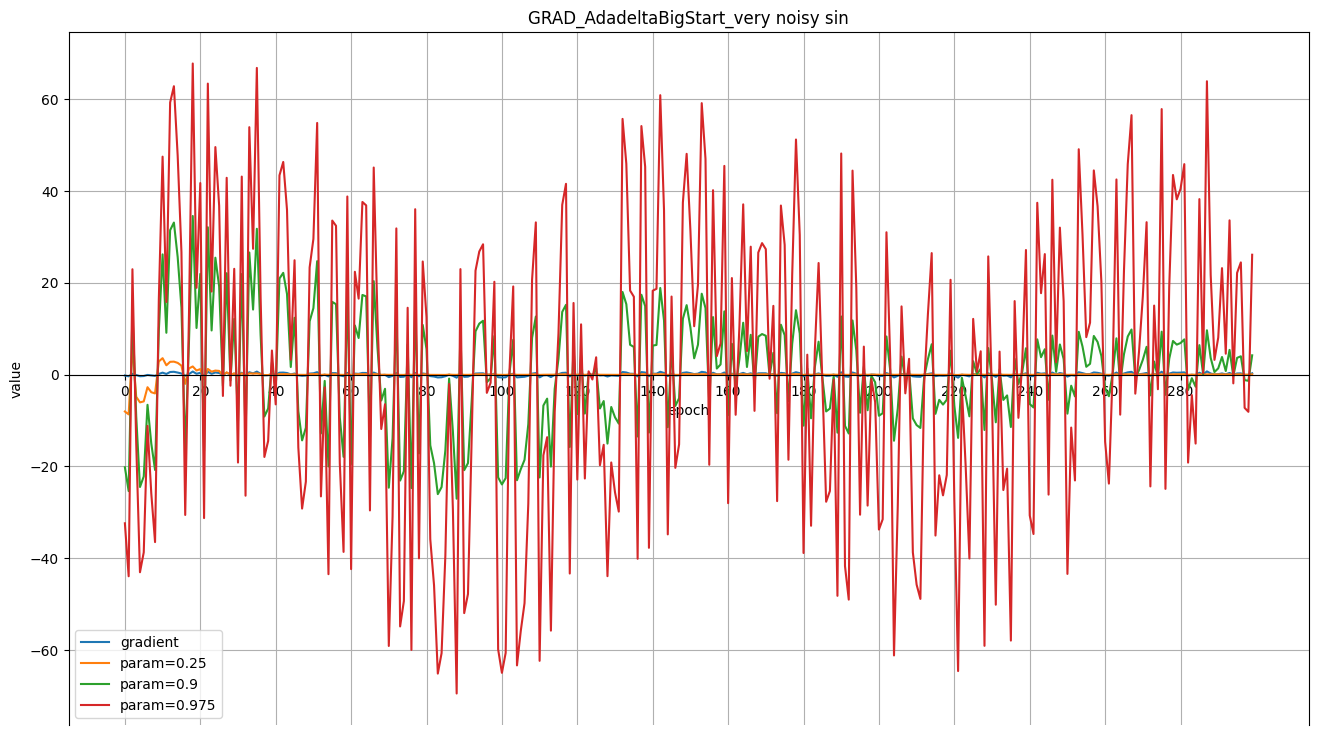

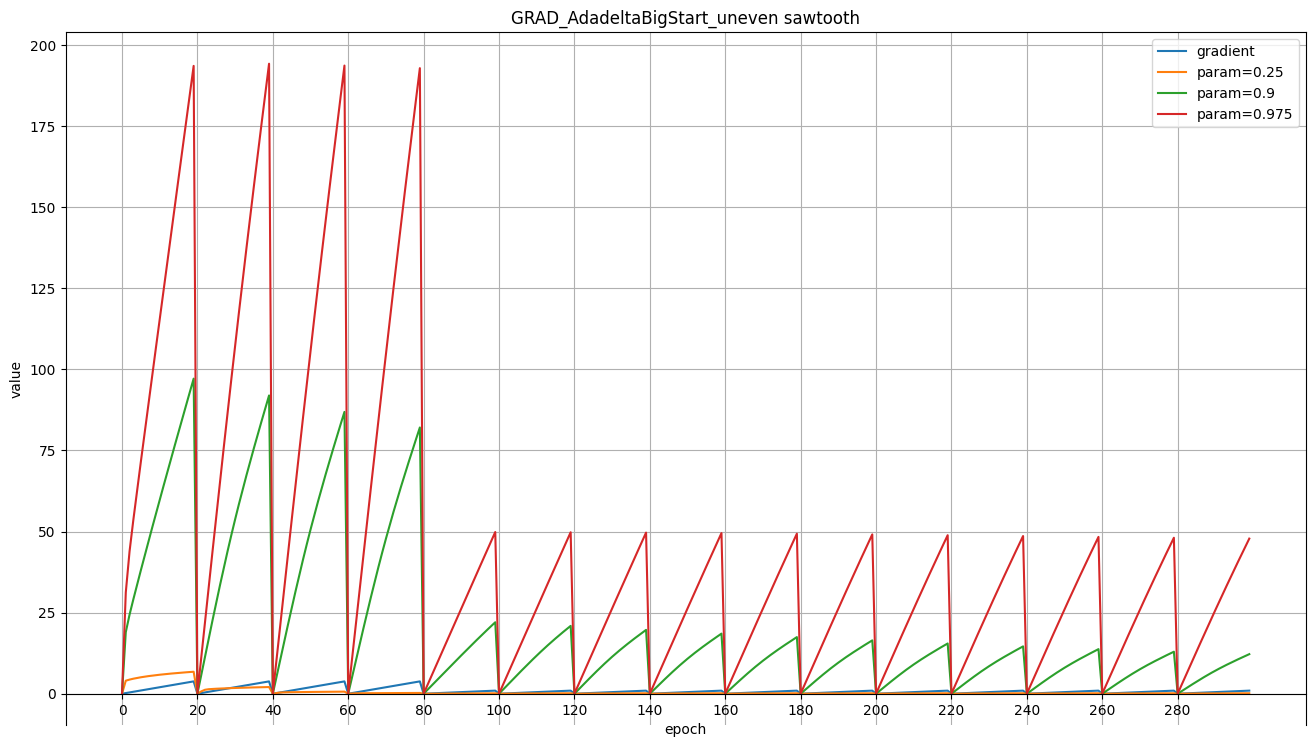

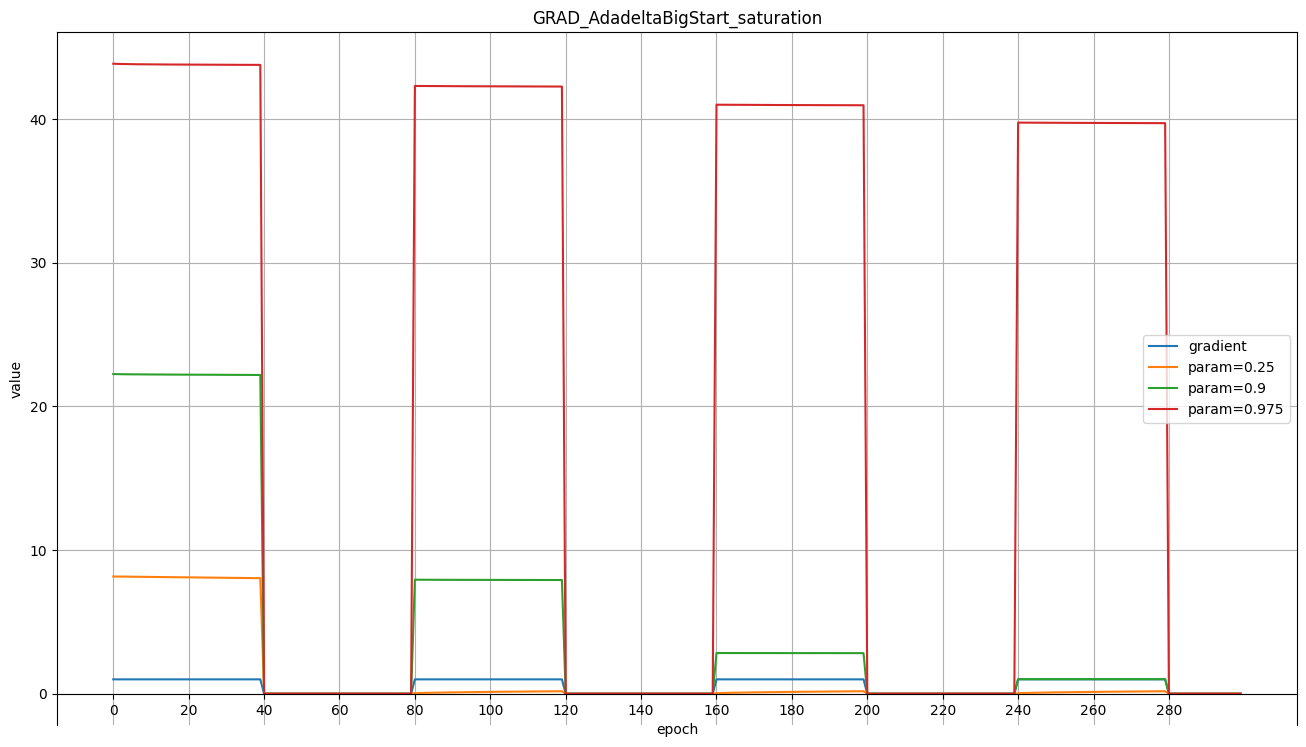

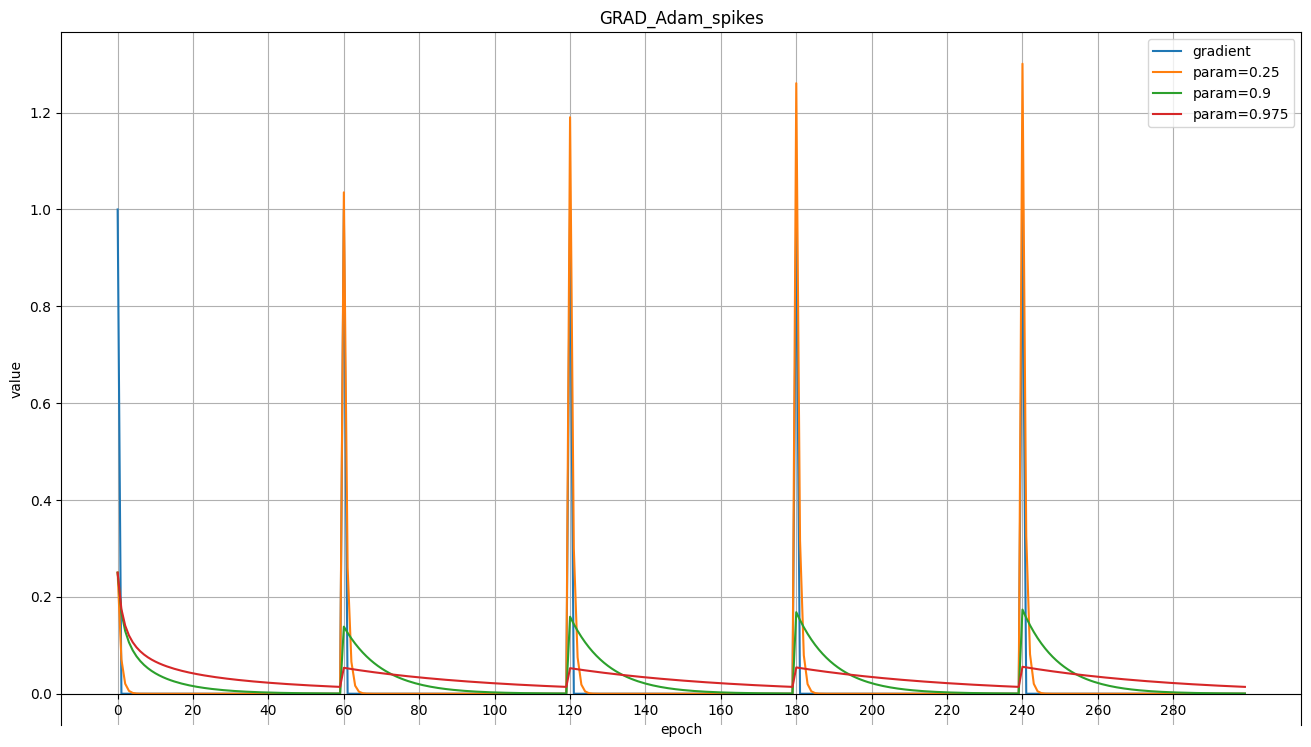

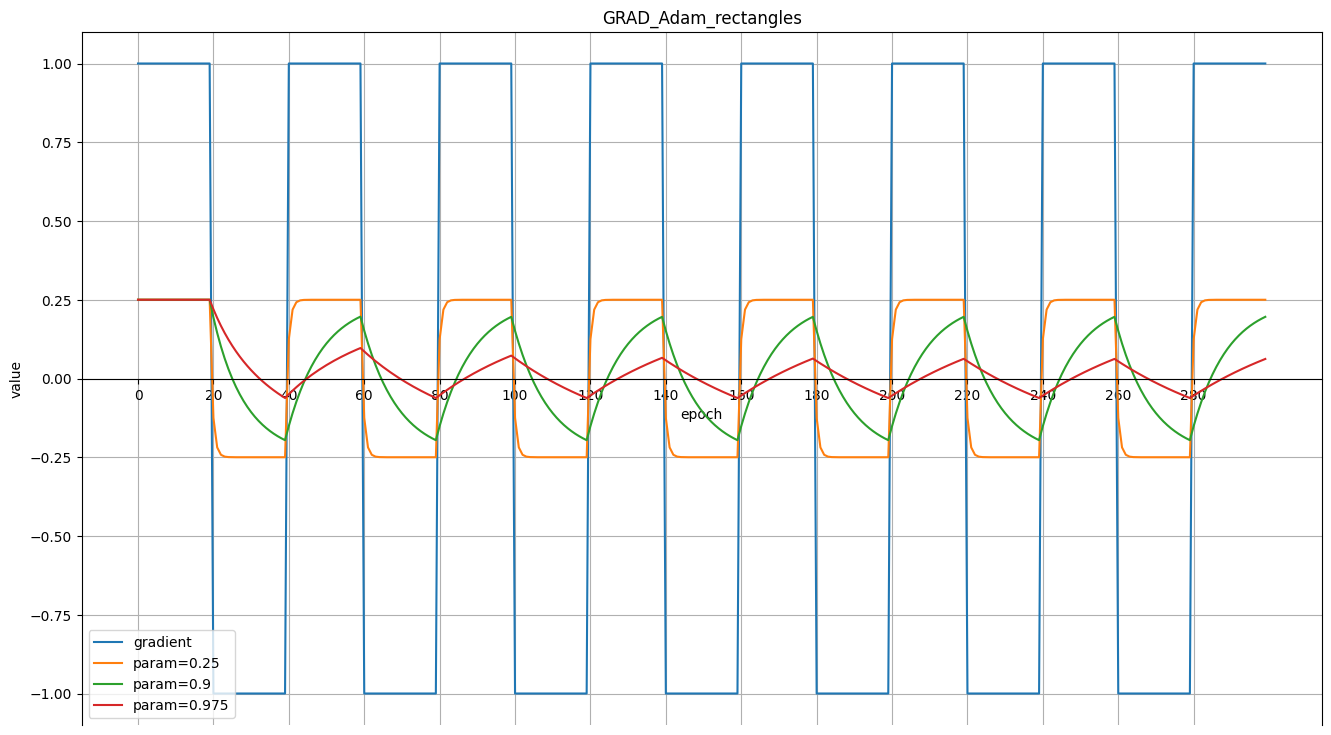

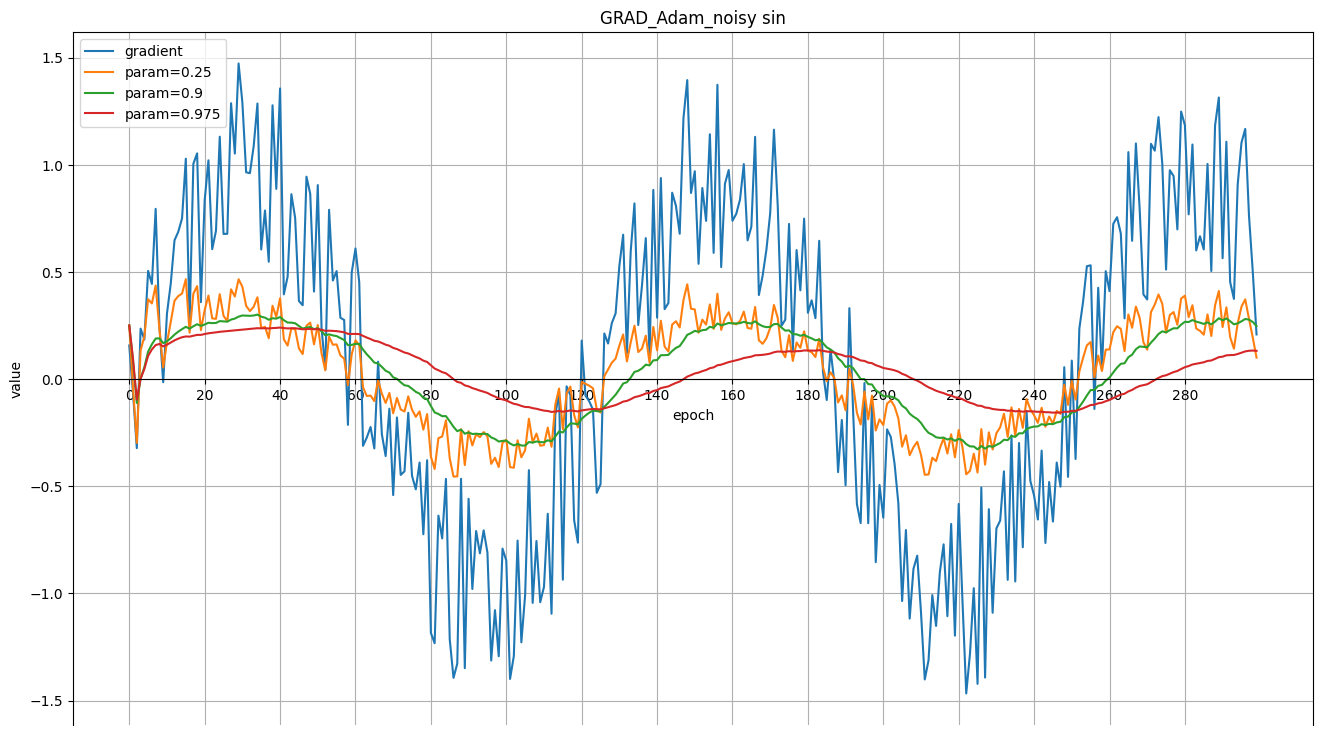

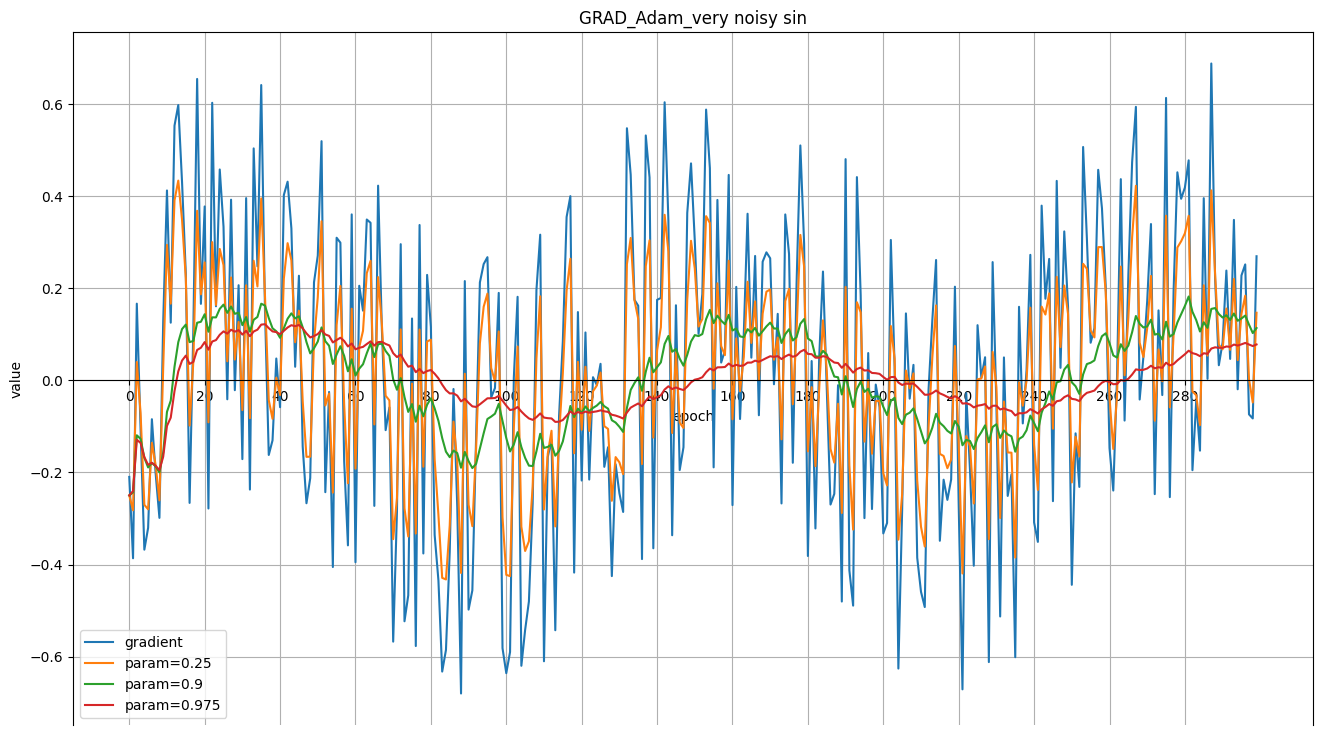

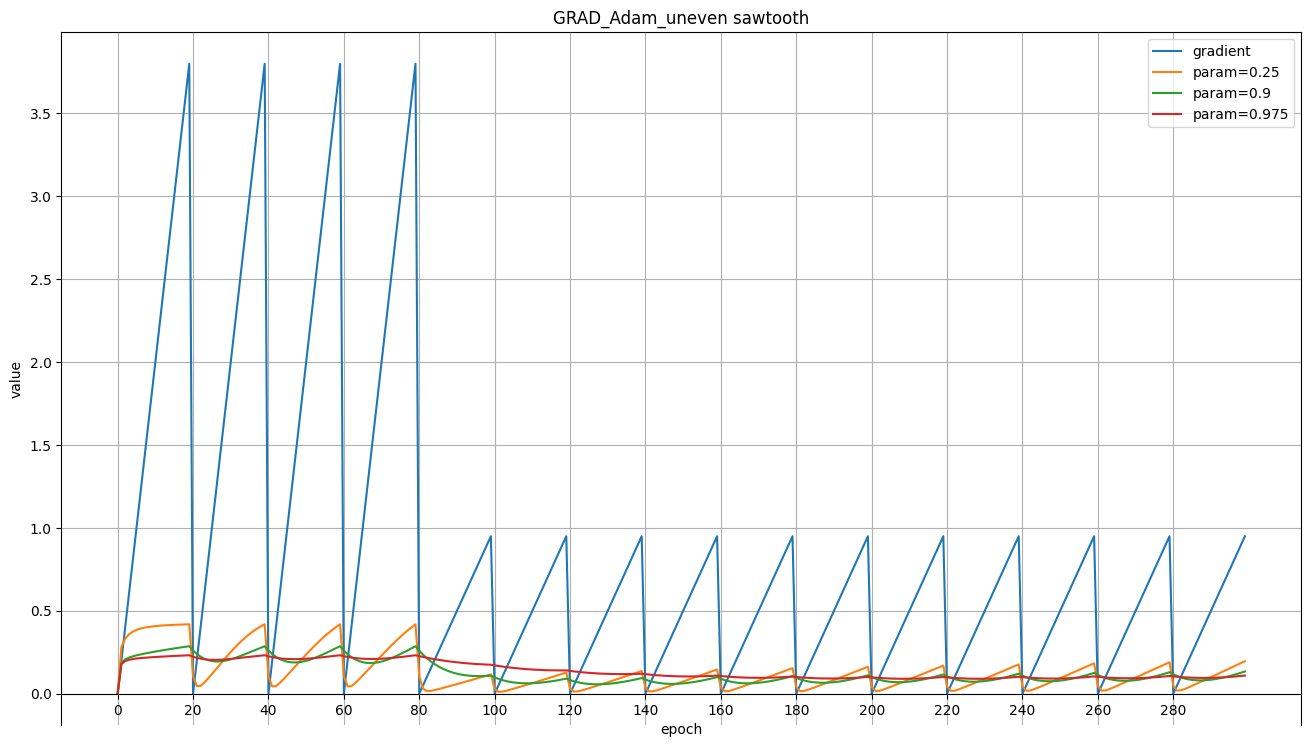

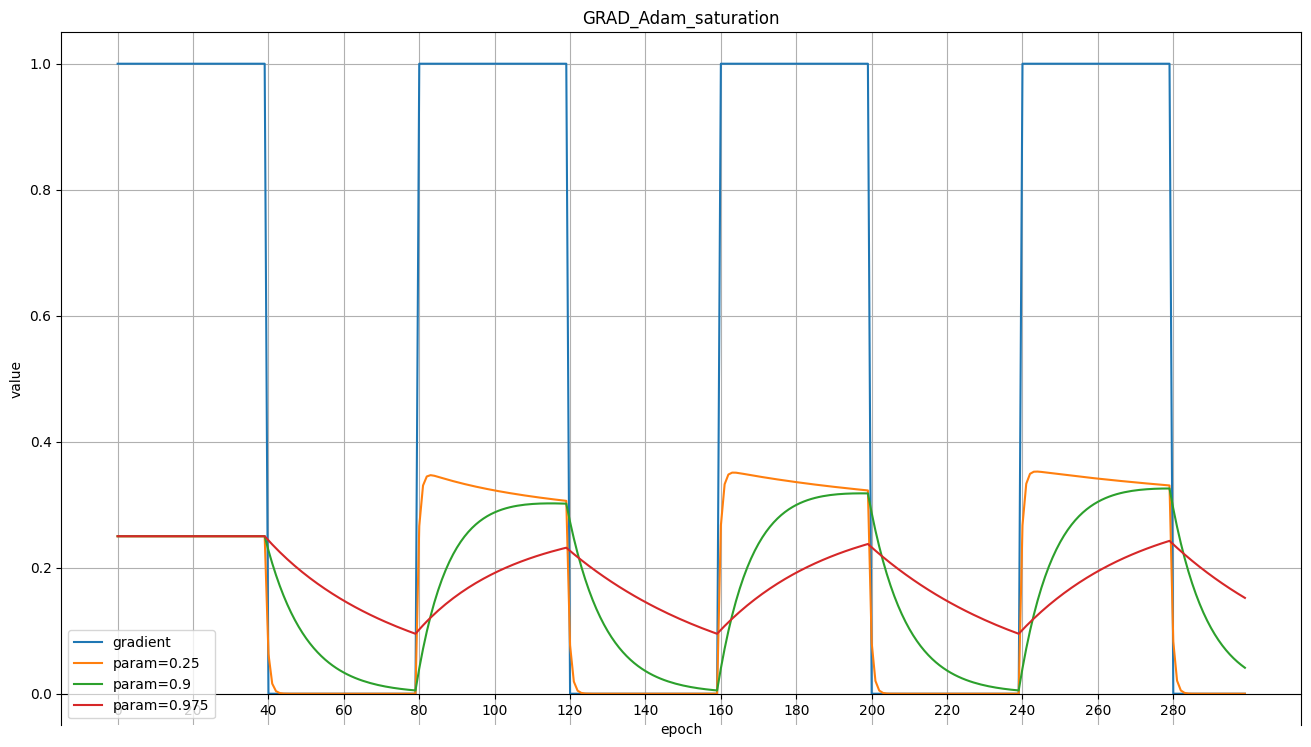

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from math import ceil, floor

def linear_interpolation(X, idx):
    idx_min = floor(idx)
    idx_max = ceil(idx)
    if idx_min == idx_max or idx_max >= len(X):
        return X[idx_min]
    elif idx_min < 0:
        return X[idx_max]
    else:
        return X[idx_min] + (idx - idx_min)*X[idx_max]

def EDM(X, gamma, lr=0.25):
    Y = []
    v = 0
    for x in X:
        v = gamma*v + lr*x
        Y.append(v)
    return np.asarray(Y)

def NM(X, gamma, lr=0.25):
    Y = []
    v = 0
    for i in range(len(X)):
        v = gamma*v + lr*(linear_interpolation(X, i+gamma*v) if i+gamma*v < len(X) else 0)
        Y.append(v)
    return np.asarray(Y)

def SmoothedNM(X, gamma, lr=0.25):
    Y = []
    v = 0
    for i in range(len(X)):
        lookahead4 = linear_interpolation(X, i+gamma*v/4)   if i+gamma*v/4      < len(X) else 0
        lookahead3 = linear_interpolation(X, i+gamma*v/2)   if i+gamma*v/2      < len(X) else 0
        lookahead2 = linear_interpolation(X, i+gamma*v*3/4) if i+gamma*v*3/4    < len(X) else 0
        lookahead1 = linear_interpolation(X, i+gamma*v)     if i+gamma*v        < len(X) else 0
        v = gamma*v + lr*(lookahead4 + lookahead3 + lookahead2 + lookahead1)/4
        Y.append(v)
    return np.asarray(Y)

def Adagrad(X, eps, lr=2.5):
    Y = []
    G = 0
    for x in X:
        G += x*x
        v = lr/np.sqrt(G + eps)*x
        Y.append(v)
    return np.asarray(Y)

def RMSProp(X, gamma, lr=0.25, eps=0.00001):
    Y = []
    EG = 0
    for x in X:
        EG = gamma*EG + (1-gamma)*x*x
        v = lr/np.sqrt(EG + eps)*x
        Y.append(v)
    return np.asarray(Y)

def Adadelta(X, gamma, lr=50.0, eps=0.001):
    Y = []
    EG = 0
    EDTheta = lr
    for x in X:
        EG = gamma*EG + (1-gamma)*x*x
        v = np.sqrt(EDTheta + eps)/np.sqrt(EG + eps)*x
        Y.append(v)
        EDTheta = gamma*EDTheta + (1-gamma)*v*v
    return np.asarray(Y)

def AdadeltaZeroStart(X, gamma, eps=0.001):
    return Adadelta(X, gamma, lr=0.0, eps=eps)

def AdadeltaBigStart(X, gamma, eps=0.001):
    return Adadelta(X, gamma, lr=50.0, eps=eps)

def Adam(X, beta1, beta2=0.999, lr=0.25, eps=0.0000001):
    Y = []
    m = 0
    v = 0
    for i, x in enumerate(X):
        m = beta1*m + (1-beta1)*x
        v = beta2*v + (1-beta2)*x*x
        m_hat = m/(1- pow(beta1, i+1) )
        v_hat = v/(1- pow(beta2, i+1) )
        dthetha = lr/np.sqrt(v_hat + eps)*m_hat
        Y.append(dthetha)
    return np.asarray(Y)

np.random.seed(413)
X = np.arange(0, 300)

D_Thetha_spikes = np.asarray( [int(x%60 == 0) for x in X])
D_Thetha_rectangles = np.asarray( [2*int(x%40 < 20) - 1 for x in X])
D_Thetha_noisy_sin = np.asarray( [np.sin(x/20) + np.random.random() - 0.5 for x in X])
D_Thetha_very_noisy_sin = np.asarray( [np.sin(x/20)/5 + np.random.random() - 0.5 for x in X])
D_Thetha_uneven_sawtooth = np.asarray( [ x%20/(15*int(x > 80) + 5) for x in X])
D_Thetha_saturation = np.asarray( [ int(x % 80 < 40) for x in X])

for method_label, method, parameter_step in [
                ("GRAD_Simple_Momentum", EDM, [0.25, 0.9, 0.975]),
                ("GRAD_Nesterov", NM, [0.25, 0.9, 0.975]),
                ("GRAD_Smoothed_Nesterov", SmoothedNM, [0.25, 0.9, 0.975]),
                ("GRAD_Adagrad", Adagrad, [0.0000001, 0.1, 10.0]),
                ("GRAD_RMSProp", RMSProp, [0.25, 0.9, 0.975]),
                ("GRAD_AdadeltaZeroStart", AdadeltaZeroStart, [0.25, 0.9, 0.975]),
                ("GRAD_AdadeltaBigStart", AdadeltaBigStart, [0.25, 0.9, 0.975]),
                ("GRAD_Adam", Adam, [0.25, 0.9, 0.975]),
            ]:
    for label, D_Thetha in [("spikes", D_Thetha_spikes),
                            ("rectangles", D_Thetha_rectangles),
                            ("noisy sin", D_Thetha_noisy_sin),
                            ("very noisy sin", D_Thetha_very_noisy_sin),
                            ("uneven sawtooth", D_Thetha_uneven_sawtooth),
                            ("saturation", D_Thetha_saturation), ]:
        fig = plt.figure(figsize=[16.0, 9.0])
        ax = fig.add_subplot(111)

        ax.plot(X, D_Thetha, label="gradient")
        for gamma in parameter_step:
            Y = method(D_Thetha, gamma)
            ax.plot(X, Y, label="param="+str(gamma))

        ax.spines['bottom'].set_position('zero')
        full_name = method_label + "_" + label

        plt.xticks(np.arange(0, 300, 20))
        plt.grid(True)
        plt.title(full_name)
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.legend()
        plt.show(block=True) #Uncoomment and comment next line if you just want to watch
        # plt.savefig(full_name)
        plt.close(fig)
